# Taller Tema 1

## Integrantes

* Francisco Gonzalez
* Bernardo Pinninghoff
* Maximiliano Sepulveda

## Codigo de honor

Este cuaderno ha sido desarrollado por los 3 integrantes del grupo siguiendo el codigo de honor UTFSM.


<table align='left'>
<tr>
<td><img src='https://www.hydro.com/globalassets/08-about-hydro/hydro-worldwide/netherlands/pp-tulips.jpg' width='900'/> </td>
</tr>
</table>


## Objetivos de aprendizaje
Al final de este taller el/la alumno/a sabrá:

> * Distinguir las funciones de las principales librerías en Python para el manejo y análisis exploratorio de datos.
> * Aplicar técnicas de visualización para generar gráficos que le permitan llegar a conclusiones descriptivas acerca de una muestra.
> * Obtener estadísticas de tendencia y dispersión univariadas sobre las variables presentes en la muestra.
> * Aplicar transformaciones sobre conjuntos de datos que le permitan, posteriormente, preparár los datos de la muestra para realizar un proceso de modelamiento.



## Datos

En este taller se utilizará el dataset `Energy consumption of the Netherlands`, disponible libremente en [Kaggle](https://www.kaggle.com/lucabasa/dutch-energy). Este dataset contiene información histórica sobre la red de energía, manejada por distintas compañías en los Paises Bajos para distintas áreas agregadas por el código postal. Vale la pena notar que, como se indica en la página del dataset, el mercado es no competitivo, es decir, solo una compañía es la encargada de entregar servicios a un determinado sector (descrito por el código postal), lo que implica que no hay fuga de clientes de una compañía a otra a través de los años.

En la carpeta entregada para este taller se muestran dos sub-carpetas:

> - **Electricity:** Contiene varios archivos en formato csv con un nombre que sigue la sintáxis:`<nombreEmpresa>_electricity_<año>.csv`, donde `nombreEmpresa` es el nombre de la empresa proveedora de electricidad.


> - **Gas:** Contiene varios archivos en formato csv con un nombre que sigue la sintáxis:`<nombreEmpresa>_gas_<año>.csv`, donde `nombreEmpresa` es el nombre de la empresa proveedora de gas.

Con respecto a las variables medidas, se debe notar que slgunas empresas proveedoras miden algunas características adicionales, para efectos de este estudio se le sugiere conservar las variables comunes a todas las empresas:

- `net_manager`: Código del administrador regional de la red o nombre del mismo.
- `purchase_area`: Código del área de donde es comprada la energía.
- `street`: Nombre de la calle de las viviendas registradas.
- `zipcode_from`: Código postal _"inicial"_ que define la zona (junto con `zipcode_to`) resumida en el registro.
- `zipcode_to`: Código postal _"final"_ que define la zona (junto con `zipcode_from`) resumida en el registro.
- `city`: Ciudad de las viviendas.
- `num_connections`: Número de conexiones en el rango de los códigos postales.
- `delivery_perc`: Porcentaje del consumo neto de electricidad o gas. Mientras más bajo significa que hubo mayor retorno de energía a la red, por ejemplo, mediante paneles solares.
- `perc_of_active_connections`: Procentaje de conexiones activas en el rango definido por los códigos postales.
- `type_conn_perc`: Porcentaje del principal tipo de conexión en el rango definido por los códigos potales, es decir, es el porcentaje del que corresponde el tipo de conexión que es moda dentro del espacio muestreado, con respecto a todos los tipos de conexiones de esa misma zona.
- `type_of_connection`: Principal tipo de conexión en la zona definida por los rangos de código postal.
- `annual_consume`: Consumo anual extraído de la red, en $kW/h$ (kilowatt por hora) para electricitdad y $m^3$ para gas.



In [1]:
#!wget www.inf.utfsm.cl/~jnancu/netherlands-energy.zip
#!unzip netherlands-energy.zip

In [2]:
BASE_DATA_PATH = 'netherlands-energy'
!ls 'netherlands-energy'

'Electricity Corrected'  'Gas Corrected'


Como ayuda, el código de más abajo carga todos los archivos csv en un único dataframe conservando la información del año.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from glob import glob
from IPython.display import display # Para usar la funcion "display()"
import re

plt.rcParams['figure.figsize'] = (15,10)

selected_cols = ["net_manager" ,"purchase_area", "street", "zipcode_from", "zipcode_to", "city", "num_connections", "delivery_perc", "perc_of_active_connections",
                 "type_conn_perc", "type_of_connection", "annual_consume", "year"]

# Si no han tenido mucha experiencia con comprensiones de lista probablemente l@s alumn@s opten por ciclos simples

# Electricity
list_dfs_electricity = []
for file_path in glob(f'{BASE_DATA_PATH}/Electricity Corrected/*.csv'):
  yr = file_path.split('_')[-1].split('.')[0]
  if '0101' in yr:
    yr = yr.replace('0101', '')
  this_df = pd.read_csv(file_path)
  this_df['year'] = int(yr)
  list_dfs_electricity.append(this_df)

df_electricity = pd.concat(list_dfs_electricity)
df_electricity = df_electricity[selected_cols]

# Gas
list_dfs_gas = []
for file_path in glob(f'{BASE_DATA_PATH}/Gas Corrected/*.csv'):
  yr = file_path.split('_')[-1].split('.')[0]
  if '0101' in yr:
    yr = yr.replace('0101', '')
  this_df = pd.read_csv(file_path)
  this_df['year'] = int(yr)
  list_dfs_gas.append(this_df)

df_gas = pd.concat(list_dfs_gas)
df_gas = df_gas[selected_cols]

Crearemos dos variables interesantes para análisis:

*   `self_production`: cantidad de energía autoproducida por los hogares (a través por ejemplo de paneles solares).
*   `consume_per_conn`: consumo medio de energía por conexión en una determinada zona.

In [4]:
df_electricity['net_annual_cons'] = df_electricity['annual_consume'] * df_electricity['delivery_perc'] / 100
df_electricity['self_production'] = df_electricity['annual_consume'] - df_electricity['net_annual_cons']
df_gas['net_annual_cons'] = df_gas['annual_consume'] * df_gas['delivery_perc'] / 100
df_gas['self_production'] = df_gas['annual_consume'] - df_gas['net_annual_cons']

df_electricity['consume_per_conn'] = df_electricity['annual_consume'] / (df_electricity['num_connections'] * df_electricity['perc_of_active_connections'] / 100)
df_electricity.loc[df_electricity['consume_per_conn'] == np.inf, 'consume_per_conn'] = 0
df_gas['consume_per_conn'] = df_gas['annual_consume'] / (df_gas['num_connections'] * df_gas['perc_of_active_connections'] / 100)
df_gas.loc[df_gas['consume_per_conn'] == np.inf, 'consume_per_conn'] = 0

## Problema de Estudio
Usted trabaja entregando servicios de consultoría y su actual cliente resulta ser una firma de inversionistas quienes están interesados en evaluar el desempeño del mercado de la energía eléctrica y de gas en los Países Bajos. La firma de inversionistas debe decidir si realizar una inversión y requiere por lo tanto conocer el estado del mercado de la energía en este país. Le encargan a usted la tarea de estudiarlo a partir de la muestra entregada en la sección anterior.

Para efectos de este estudio escoja un tipo de energía a estudiar y responda a las inquietudes de los clientes. Específicamente su cliente necesita alcarar al menos los siguientes puntos:




## Requerimientos del cliente (10 pts. c/u)

1.  ¿Cuáles son las 10 ciudades que consumieron más energía eléctrica el 2020? ¿Son las mismas 10 que consumieron una mayor cantidad anual de gas? Entregue estadísticas y un gráfico apropiado para apoyar su respuesta. ¿Tiene sentido lo que observa?

2.  ¿Cuál es el grado de acaparamiento que se observa en el mercado eléctrico nacional durante 2020? ¿En el mercado del gas? Responda analizando el número de conexiones por proveedor y la energía consumida por esas conexiones. Entregue medidas de tendencia y un gráfico apropiado para apoyar su respuesta.

3. ¿Cuánta energía consumió una conexión a la red durante 2020? Responda construyendo un histograma que muestre cómo se distribuye la cantidad de energía por conexión durante 2020. Describa el histograma en términos de modas, simetría, y sesgo. Entregue además estadísticas de tendencia y dispersión. Comente.

4. Considere las 3 ciudades con más conexiones y las 3 ciudades con menos conexiones durante 2020. Compare el consumo por conexión de esas 6 ciudades. ¿Depende esta variable del tamaño de la ciudad? ¿Existen en estas ciudades zonas con consumo inusualmente pequeño o inusualmente grande por conexión?

5. ¿Cuánta energía auto-generaron los hogares durante 2020? Responda construyendo y describiendo un gráfico que muestre cómo se distribuye la cantidad de energía total consumida por los hogares durante 2020, la cantidad de energía autogenerada ese año, y la fracción de la energía consumida que es autogenerada por los hogares. Comente. 

6. Considere las 3 ciudades con más conexiones y las 3 ciudades con menos conexiones durante 2020. Compare la distribución de la cantidad de energía auto-generada en esas 6 ciudades. ¿Depende esta variable del tamaño de la ciudad? ¿Existen en estas ciudades zonas con consumo auto-generado inusualmente pequeño o inusualmente grande?

7. ¿Existe una relación entre el consumo anual y la cantidad de conexiones de una ciudad? ¿Entre el consumo anual y la cantidad de energía auto-generada en la ciudad? 

8. ¿Está aumentado el consumo de gas en el país? ¿El consumo de electricidad? ¿Está aumentando o disminuyendo más un tipo de consumo que otro? Para abordar esta pregunta, desagregue los datos por año y ciudad, presentando gráficos que permitan comparar fácilmente tanto tendencia como dispersión. Limítese a estudiar lo que sucede en las 10 ciudades con más conexiones. Comente lo que observa.

9. ¿Está aumentado la cantidad de energía auto-generada en el país? Para abordar esta pregunta, desagregue los datos por año y ciudad, presentando gráficos que permitan comparar fácilmente tanto tendencia como dispersión. Limítese a estudiar lo que sucede en las 10 ciudades con más conexiones.  Comente lo que observa.

10. Proponga y desarrolle un análisis libre que no haya sido cubierto y que esté relacionada al objetivo del cliente (saber en qué empresas o ciudades o tipos de conexion invertir). Resuma también las principales conclusiones del estudio.

## Consejos y tips para su desarrollo
- Familiaricese con los tipos de datos que implementa pandas.
- Probablemente le sirva familiarizarse con las formas de hacer filtros según condiciones booleanas en pandas.
- La columna `type_conn_perc` presenta un pequeño problema: El punto flotante está especificado con una coma (`,`) en lugar de un punto (`.`), esto hace que pandas interprete los valores de esa columna como `object` cuando en realidad debiesen estar como tipo `float`, estudie como coercionar una columna en pandas de un tipo de dato a otro y somo aplicar transformaciones sobre cada uno de los elementos dentro de una columna (método `.apply()` por ejemplo).
- Puede agrupar datos de acuerdo a alguna columna de interés y después aplicar alguna función de agregación sobre alguna/s columna/s de interés con los métodos `.groupby()` y `.agg()` de la clase `DataFrame` y `GroupedDataFrame` respectivamente. Por ejemplo, si quisiese saber la cantidad de conexiones por ciudad podría agrupar por ciudad y agregar la columna `num_connections` con una operación de suma.
- Algunas funciones de visualización de la librería `seaborn` permiten la desagregación de los gráficos de acuerdo alguna variable categórica (idealmente) mediante la incorporación del parámetro `hue` en su firma, vea la documentación del método para saber como usarlo en caso de que lo requiera.




## Formalidades & Reglas


*   **Fecha límite:** la recopilación de las soluciones para corrección se hará el día martes 29 de Marzo a las 08:00 hrs. 
 
*   La solución debe desarrollarse como extensión del cuaderno con los enunciados, cambiando el nombre del archivo a *Taller1_INF280_I_2022_ENTREGA_NOMBRE_EQUIPO.ipynb*.

*  Se debe trabajar en equipos de 3 personas identificadas al inicio del cuaderno con la solución. Excepciones a esta regla deben ser conversadas con los profesores.

*  Pueden utilizar Python o R. Pueden re-usar código visto en clases y/o recolectar código/ideas de otros sitios, mencionando al autor y entregando un link a la fuente.

*  Es posible utilizar apuntes, libros, y cualquier otro material que desee, pero debe ser el equipo quien desarrolle los ejercicios y comente los resultados en el cuaderno que entregará.

*  Tener roles dentro del equipo está bien, pero al final del proceso, cada miembro debe entender y estar en condiciones de exponer todo el trabajo realizado.

*  Además del cuaderno, cada estudiante debe entregar un video (<=20 minutos) explicando lo que se hizo. Mientras se da la explicación, se debe recorrer el cuaderno con la solución enfatizando el análisis y las conclusiones (no detalles de código). Los videos debe ser subidos a una plataforma externa (Youtube, Google Drive, Dropbox, etc). Se deben sólo incluir links dentro del cuaderno, recordando otorgar los permisos para que se pueda revisar.

# **Desarrollo**

## 1. 10 ciudades que mas consumen energia electrica y gas en 2020

Primero, **debemos filtrar los datos** por año para que unicamente tengamos la informacion de 2020, luego **debemos agrupar** los datos por ciudad, esto nos generara un DataFrame agrupado. Con esto, podemos **sumar todos los datos de cada grupo**, y asi obtener el total de consumo para cada ciudad, para asi ordenarlo y obtener las 10 primeras ciudades con mas consumo.

In [5]:
# Electricidad
df_elc_2020              = df_electricity.query('year==2020')
dfg_elc_2020_city        = df_elc_2020.groupby('city')
df_elc_2020_city_sum     = dfg_elc_2020_city['annual_consume'].agg('sum')
df_elc_2020_city_sum_t10 = df_elc_2020_city_sum.sort_values().tail(10)

# Gas
df_gas_2020                 = df_gas.query('year==2020')
dfg_gas_2020_city           = df_gas_2020.groupby('city')
df_gas_2020_city_sum        = dfg_gas_2020_city['annual_consume'].agg('sum')
df_gas_2020_city_sum_t10    = df_gas_2020_city_sum.sort_values().tail(10)

Ahora podemos graficar los datos obtenidos:

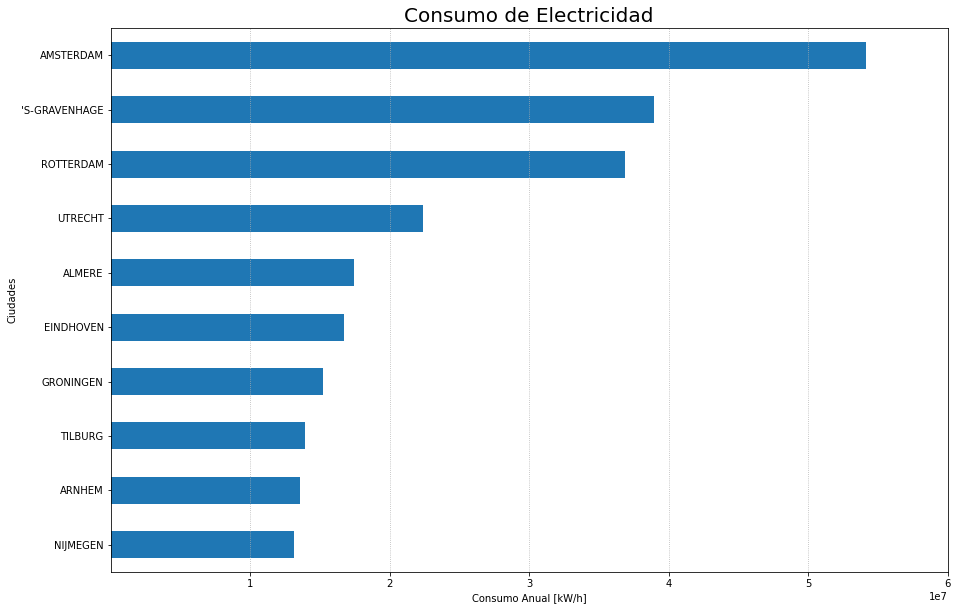

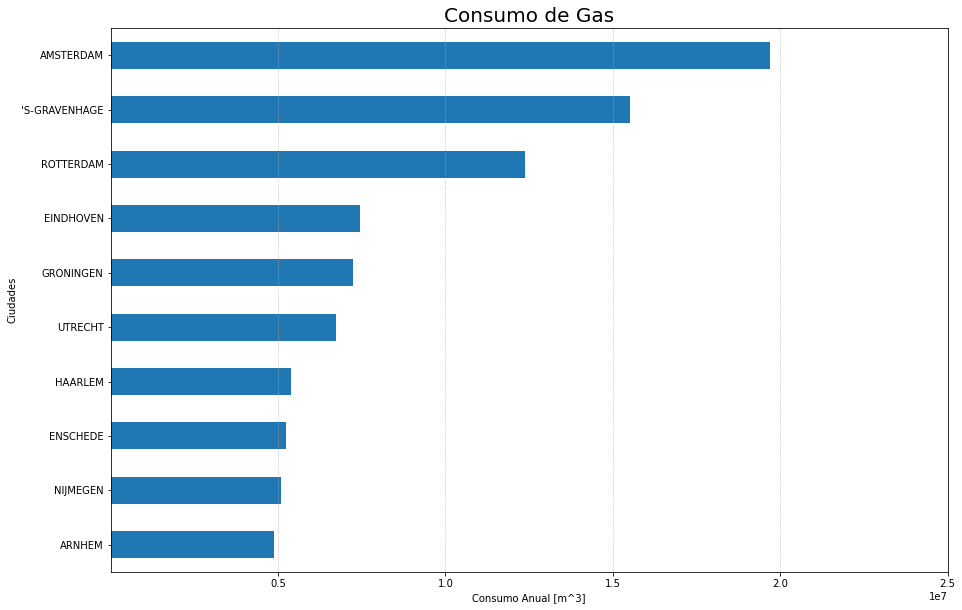

In [6]:
# Electricidad
df_elc_2020_city_sum_t10.plot(kind='barh',x='city',y='annual_consume')
plt.title('Consumo de Electricidad',fontsize=20)
plt.xlabel('Consumo Anual [kW/h]')
plt.ylabel('Ciudades')
plt.grid(axis='x',linestyle=':')
plt.xticks([1e7,2e7,3e7,4e7,5e7,6e7])
plt.show()

# Gas
df_gas_2020_city_sum_t10.plot(kind='barh',x='city',y='annual_consume')
plt.title('Consumo de Gas',fontsize=20)
plt.xlabel('Consumo Anual [m^3]')
plt.ylabel('Ciudades')
plt.grid(axis='x',linestyle=':')
plt.xticks([0.5e7,1e7,1.5e7,2e7,2.5e7])
plt.show()

Podemos observar que las primeras 3 ciudades que mas consumen electricidad son las mismas que tambien consumen mas gas; tiene sentido pues Amsterdam, Rotterdam y The Hague (S-Gravennhage) son las minucipalidades mas grandes en terminos poblacionales de los Paises Bajos. Sin embargo Eindhoven consume mas gas que Utrecht, siendo que Utrecht consume mas electricidad que Eidnhoven.

## 2. Grado de acaparamiento en el mercado electrico y de gas en 2020

Primero analizamos el negocio de la electricidad. A partir del grafico de torta se puede ver que el mercado posee tres gigantes en terminos de numero de conexiones, liander electricity, enexis electricity y stedin electricity. El mas prominente de ellos, controlando el 42% de todas las conexiones del pais siendo liander, con enexis siguiendole con el 32% de las conexiones. Una notable diferencia del 10% entre el primer y segundo lugar.

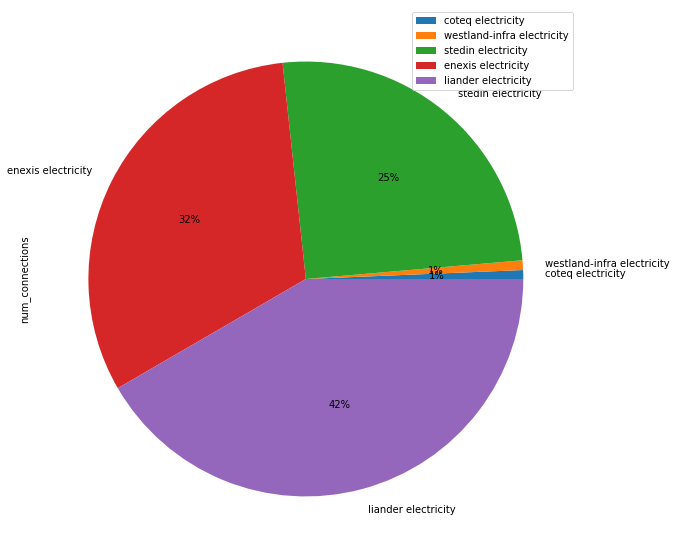

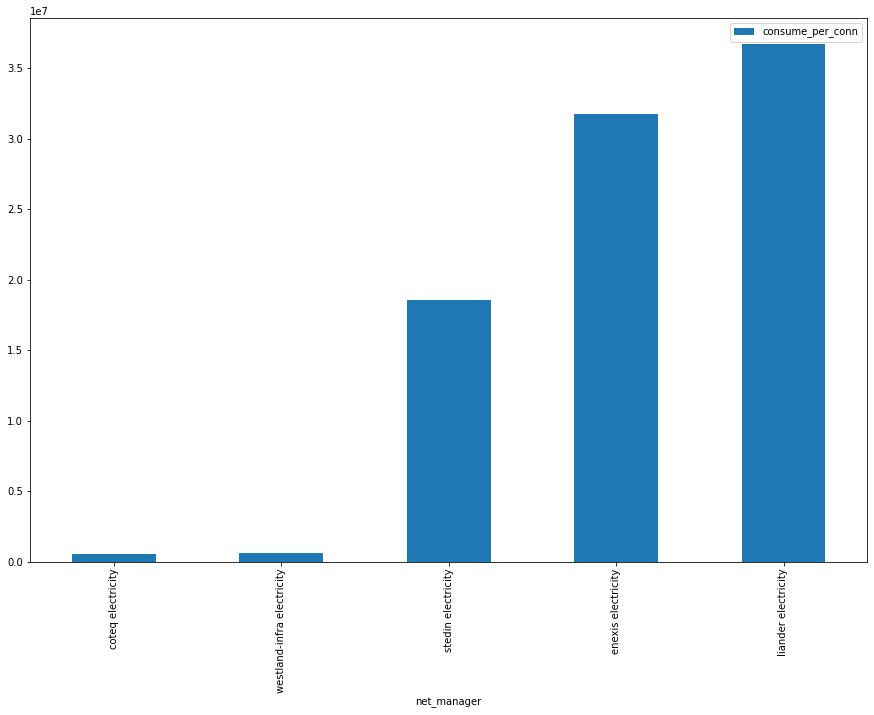

In [7]:
df_num_conn = df_elc_2020[['net_manager','num_connections']]
df_num_conn = df_num_conn.groupby('net_manager').sum().sort_values('num_connections')

df_num_conn.plot(kind='pie',subplots=True,autopct="%1.0f%%")
plt.show()


df_consume = df_elc_2020[['net_manager','consume_per_conn']]
df_consume = df_consume.groupby('net_manager').sum().sort_values('consume_per_conn')
df_consume = df_consume.reset_index()

df_consume.plot(kind='bar',x='net_manager')
plt.show()

Y luego, se ve que el patron se repite en el grafico de barra de consumo por conexion. Nuevamente se encuentran los tres gigantes anteriores, con liander electricity siendo el lider con un consumo total de mas de 3.5*10e7 kWh.

Mientras tanto, los proveedores restantes no pueden competir con los principales tres. Cotq electricity y westland-infra electricity apenas controlan el 1% de las conexiones del pais, cada uno, y el consumo en sus conexiones es infimo cuando se compara con los grandes tres. Entonces se puede decir que el mercado electrico se encuentra acaparado por los proveedores liander, enexis y stedin, teniendo a liander como el mayor proveedor de electricidad.

Despues en el mercado del gas se tiene una situacion similar. Liander gas, enexis gas y stedin gas controlan la mayoria de las conexiones en este mercado. Y nuevamente, liander es lider con 37% de todas las conexiones, aunque por una diferencia menor, del 5%, con el segundo lugar que posee enexis con el 32% de las conexiones

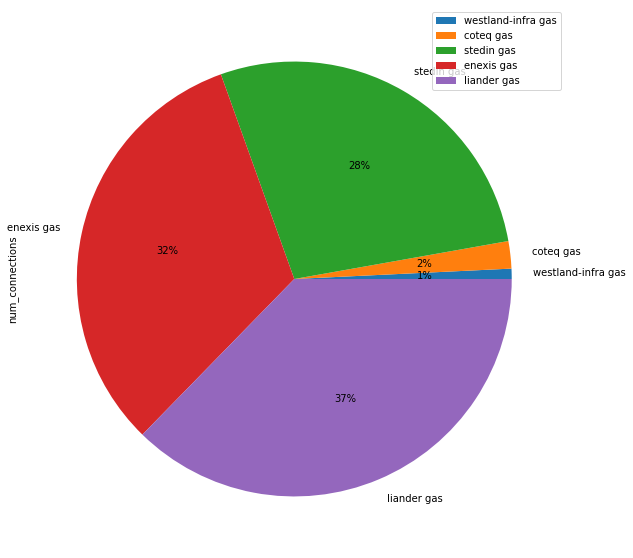

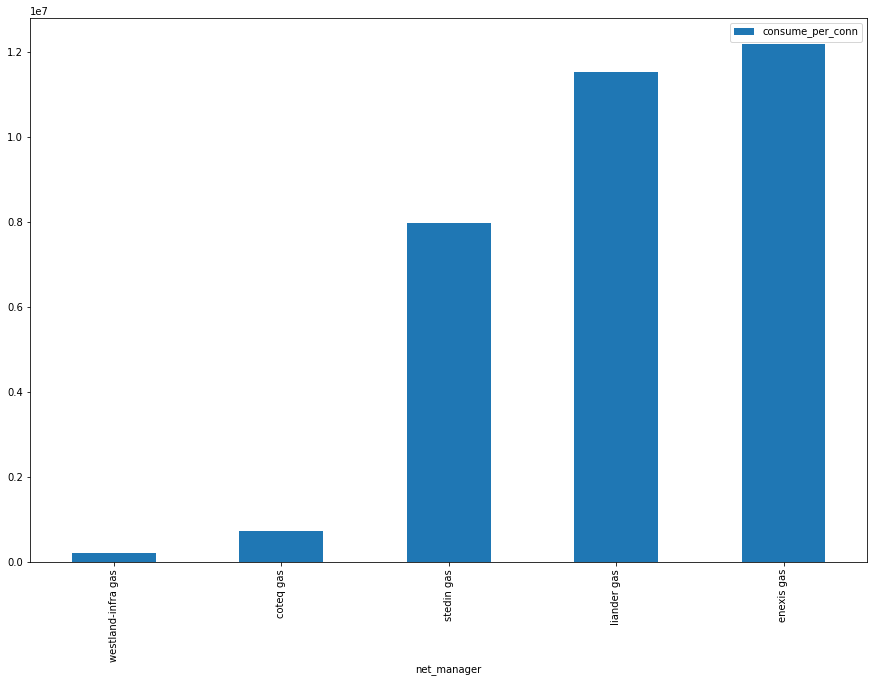

In [8]:
df_num_conn = df_gas_2020[['net_manager','num_connections']]
df_num_conn = df_num_conn.groupby('net_manager').sum().sort_values('num_connections')

df_num_conn.plot(kind='pie',subplots=True,autopct="%1.0f%%")
plt.show()


df_consume = df_gas_2020[['net_manager','consume_per_conn']]
df_consume = df_consume.groupby('net_manager').sum().sort_values('consume_per_conn')
df_consume = df_consume.reset_index()

df_consume.plot(kind='bar',x='net_manager')
plt.show()

Concerniendo el consumo por conexion, nuevamente el patron anterior se mantiene. Liander posee el mayor consumo de energia, mayor a 1.2e7 kWh. Pero enexis compite con liander, encontrandose bastante cerca a los 1.2e7 kWh.

Finalmente, tambien se tiene que los proveedores menores no pueden competir con los 3 gigantes del gas. Por lo tanto, se queda claro que tanto el mercado de la electricidad como el gas se encuentran acaparados, por los mismos tres grandes proveedores, liander, enexis y stedin.

## 3. Cantidad de energia electrica consumida por conexion en 2020

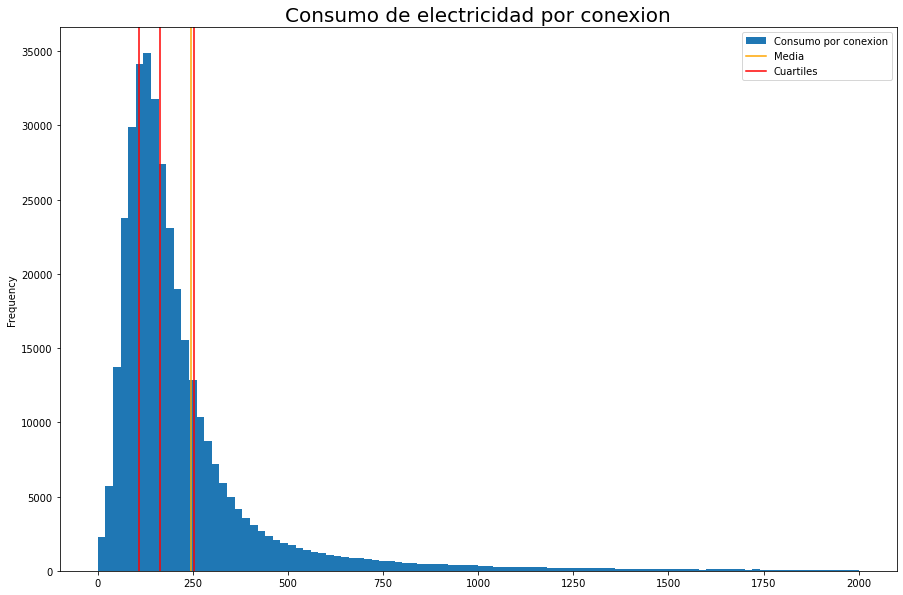

Minimo   :  0.0
Maximo   :  34637.0
Media    :  244.7670689179967
Mediana  :  162.77375
Sesgo    :  81.9933189179967
Desv Est :  365.79156531125363
Cuartiles:  108.70316980707153 162.77375 253.66666666666666


In [9]:
sr_elc_2020_consume_conn = df_elc_2020[['consume_per_conn']]

minim   = float(sr_elc_2020_consume_conn.min())
maxim   = float(sr_elc_2020_consume_conn.max())

cuartil = sr_elc_2020_consume_conn.quantile([0.25, 0.5, 0.75])
q1      = float(cuartil.loc[0.25])
q2      = float(cuartil.loc[0.50])
q3      = float(cuartil.loc[0.75])
mediana = q2

media   = float(sr_elc_2020_consume_conn.mean())
desvStd = float(sr_elc_2020_consume_conn.std())
sesgo   = media - mediana

sr_elc_2020_consume_conn.plot(kind='hist',bins=100,range=(0,2000))
plt.title('Consumo de electricidad por conexion',fontsize=20)
plt.axvline(media, color='orange')
plt.axvline(q1, color='red')
plt.axvline(q2, color='red')
plt.axvline(q3, color='red')
plt.legend(['Consumo por conexion','Media','Cuartiles'])
plt.show()

print("Minimo   : ", minim)
print("Maximo   : ", maxim)
print("Media    : ", media)
print("Mediana  : ", mediana)
print("Sesgo    : ", sesgo)
print("Desv Est : ", desvStd)
print("Cuartiles: ", q1, q2, q3)

Se puede apreciar un sesgo positivo, es decir, los datos se inclinan mas a la izquierda. Tambien se ve que el 50% de las conexiones consume alrededor de 108.7 [kW/h] y 253,7 [kW/h]. No obstante notar que el mayor consumo que existe entre las conexiones es de 34637, siendo este valor un caso extremo. Esto ultimo puede ser la explicacion de la diferencia que existe entre la media y la mediana.

## 4. Comparacion de consumo en ciudades con mayor y menor cantidad de conexiones

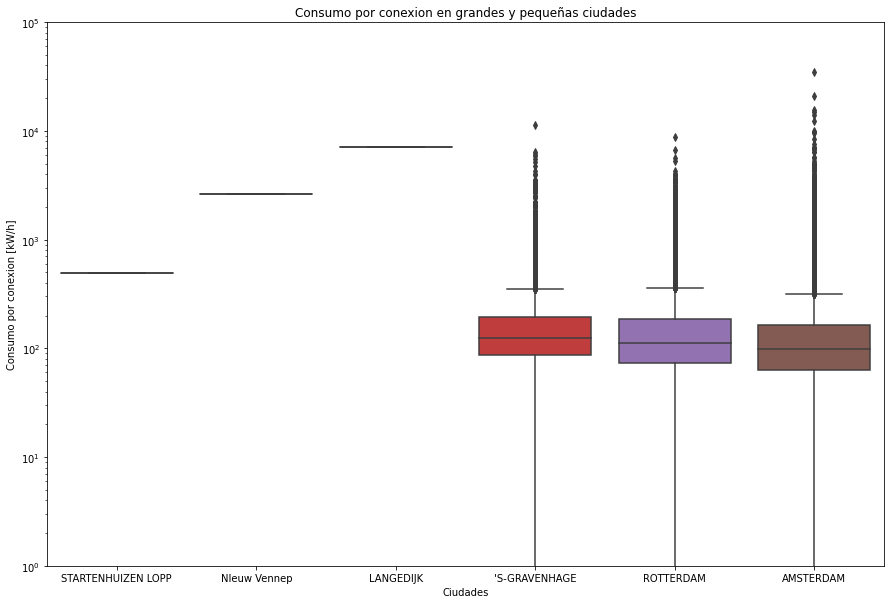

In [10]:
top3_city_conn = list(df_elc_2020[['city','num_connections']].groupby('city').sum().sort_values('num_connections').tail(3).index)
bot3_city_conn = list(df_elc_2020[['city','num_connections']].groupby('city').sum().sort_values('num_connections').head(3).index)

city_list = bot3_city_conn + top3_city_conn

df_consum_per_conn = df_elc_2020.query('city==' + str(city_list))

# display(df_consum_per_conn)

sn.boxplot(data=df_consum_per_conn, x='city', y='consume_per_conn', order=city_list)
plt.yscale('log')
plt.ylim(1,100000)
plt.title('Consumo por conexion en grandes y pequeñas ciudades')
plt.xlabel('Ciudades')
plt.ylabel('Consumo por conexion [kW/h]')
plt.show()

# df_elec_2020_conn = df_elc_2020[['city','num_connections','consume_per_conn']]
# df_elec_2020_conn = df_elec_2020_conn.groupby('city').sum()
# df_elec_2020_conn = df_elec_2020_conn.sort_values('num_connections')

# df_elec_2020_conn_min = df_elec_2020_conn.head(3)
# df_elec_2020_conn_max = df_elec_2020_conn.tail(3)
# df_elect_2020_conn_total = pd.concat([df_elec_2020_conn_min, df_elec_2020_conn_max])

# df_elect_2020_conn_total.plot(kind='bar')
# plt.yscale('log')
# plt.xlabel('Ciudades')
# plt.legend(['Numero de conexiones','Consumo por conexion promedio [kW/h]'])
# plt.show()



No, la cantidad consumida por conexion no depende del tamaño de la ciudad, sino que por el numero de conexiones; es decir, las ciudades mas pequeñas tienen menor cantidad de conexiones, sin embargo, estas ciudades pequeñas tienen consumos por conexion extremadamente elevados a comparacion de su tamaño. En las cuidades grandes obviamente se espera un alto consumo de energía, pero como hay mas conexiones, la dispersion es mas alta.

## 5. Energia auto-generada en 2020

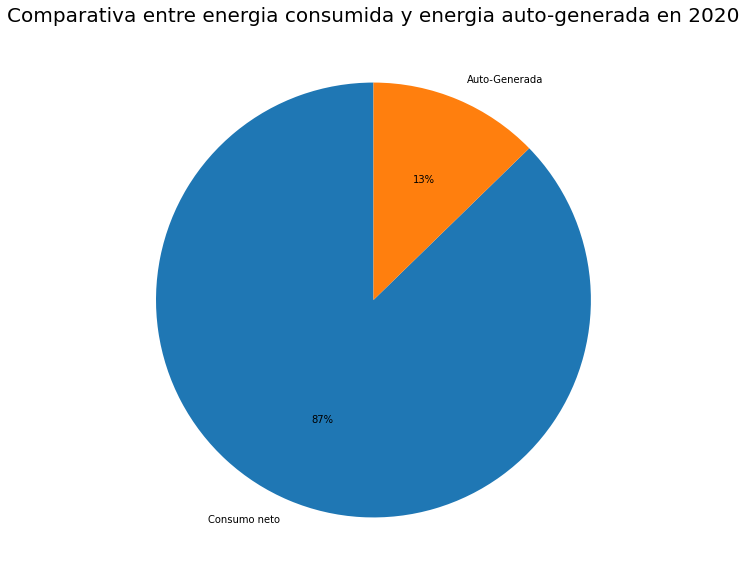

In [11]:
df_elc_2020_self = df_elc_2020[['annual_consume','net_annual_cons','self_production']]
df_elc_2020_self = df_elc_2020_self.sum()
df_elc_2020_self = df_elc_2020_self[['net_annual_cons','self_production']]


df_elc_2020_self.plot(kind='pie',startangle=90,autopct="%1.0f%%",labels=['Consumo neto','Auto-Generada'])
plt.ylabel("")
plt.title("Comparativa entre energia consumida y energia auto-generada en 2020",fontsize=20)
plt.show()

Aquí podemos apreciar la comparativa de la producción general de energía a nivel país del año 2020, donde existe un aporte de los auto consumidores, superando el 10% de lo consumido.

## 6. Comparacion de energia auto-generada en ciudades con mayor y menor cantidad de conexiones

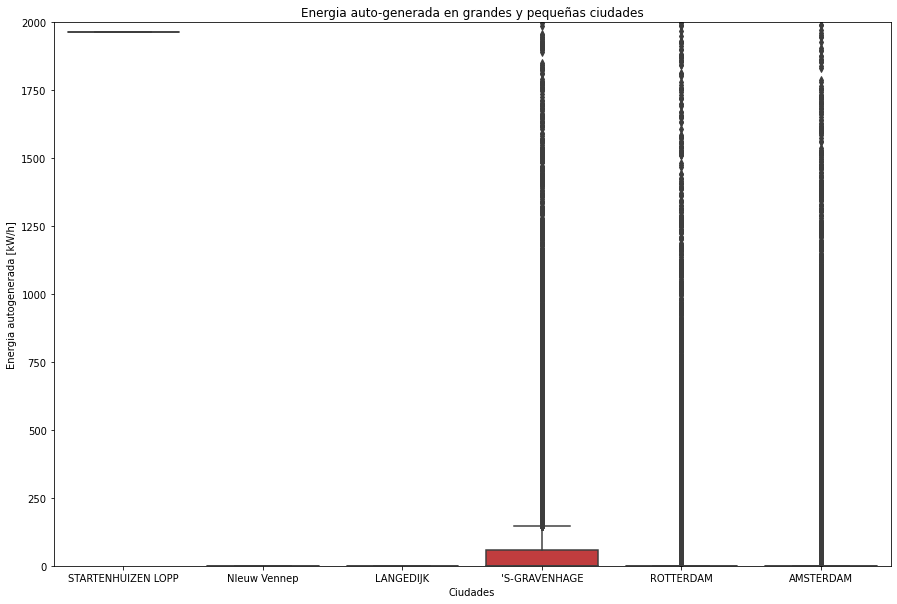

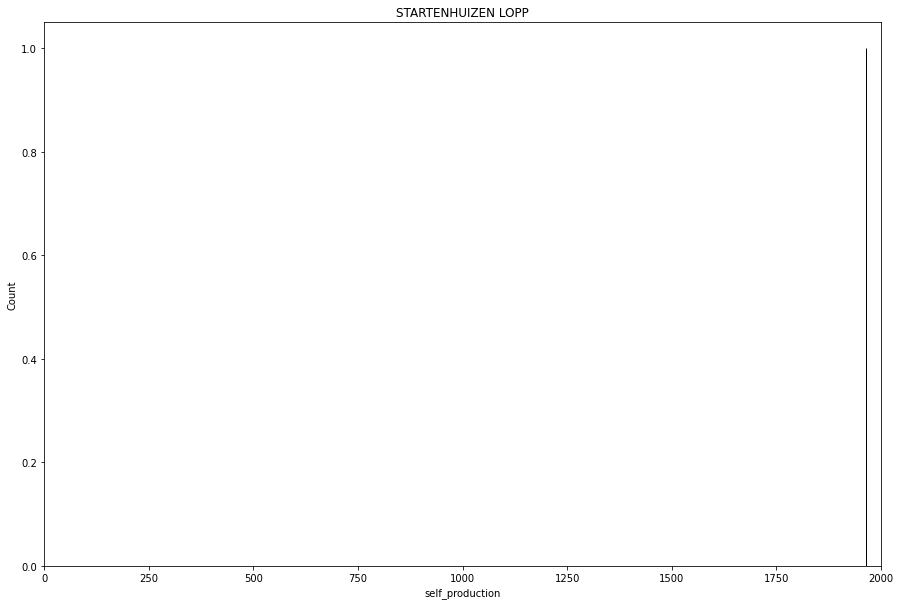

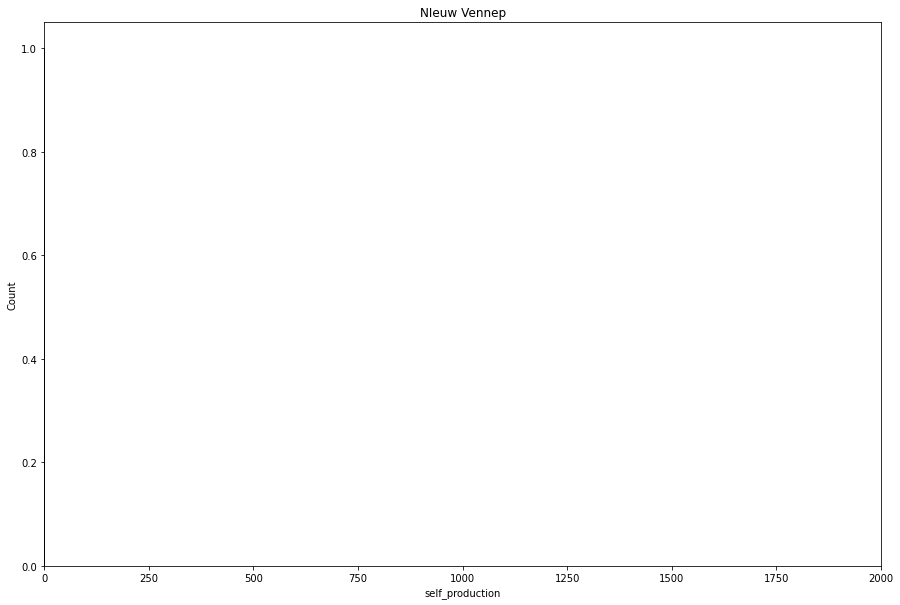

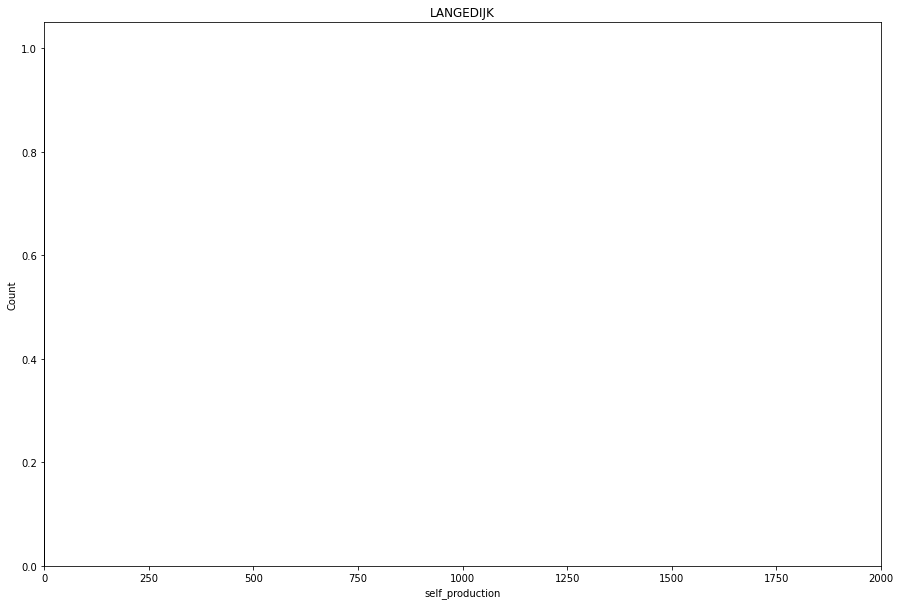

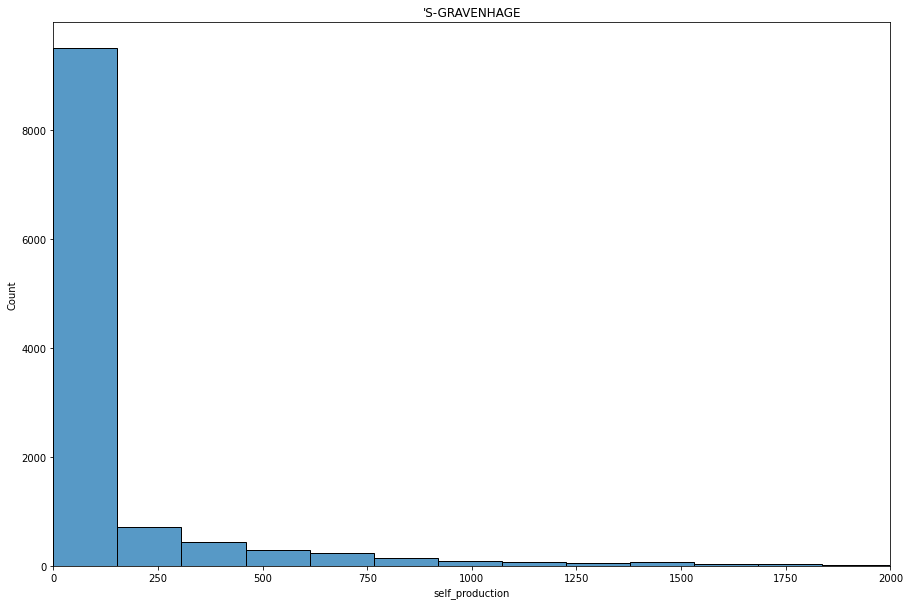

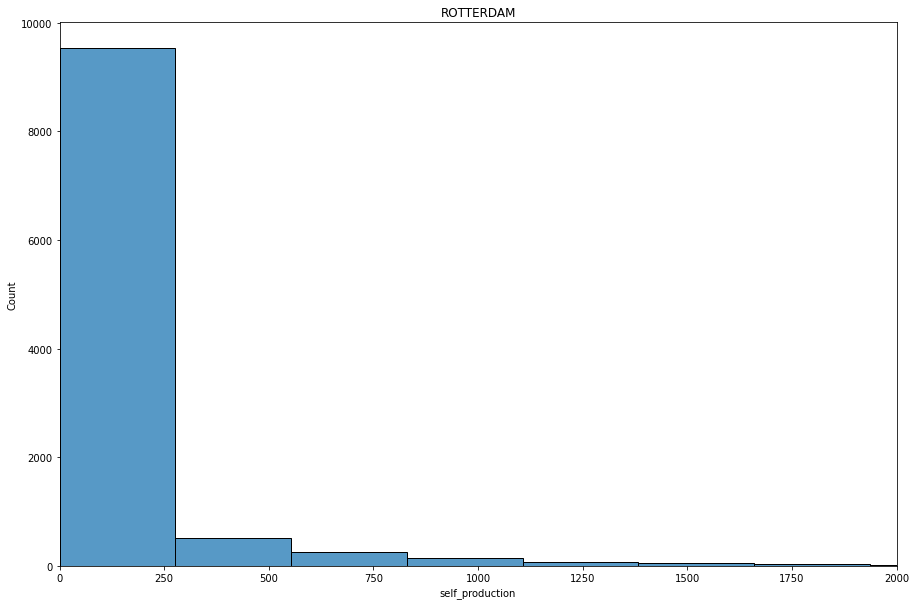

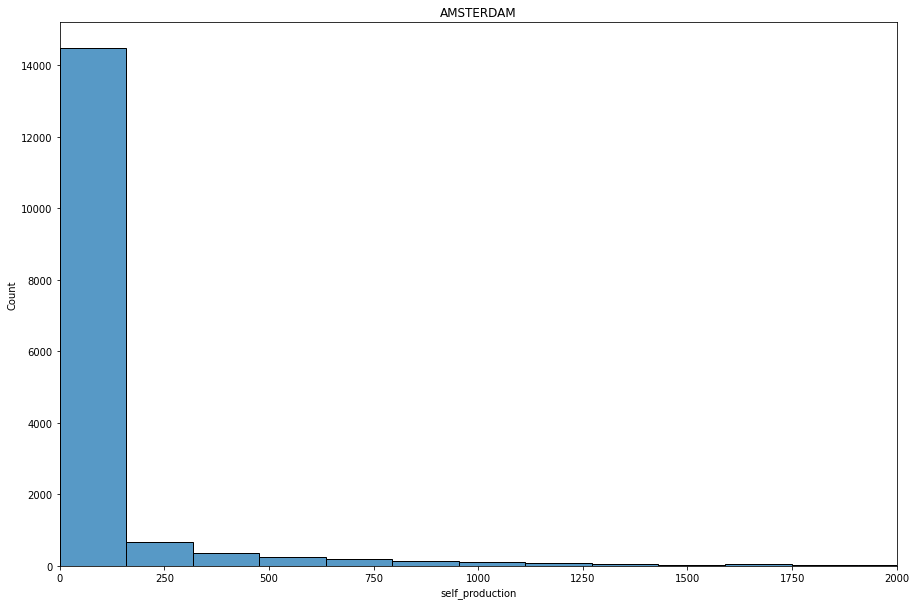

In [12]:
top3_city_conn = list(df_elc_2020[['city','num_connections']].groupby('city').sum().sort_values('num_connections').tail(3).index)
bot3_city_conn = list(df_elc_2020[['city','num_connections']].groupby('city').sum().sort_values('num_connections').head(3).index)

city_list = bot3_city_conn + top3_city_conn

df_self_production = df_elc_2020.query('city==' + str(city_list))

# display(df_self_production)

sn.boxplot(data=df_self_production, x='city', y='self_production', order=city_list)
# plt.yscale('log')
plt.ylim(0,2000)
plt.title('Energia auto-generada en grandes y pequeñas ciudades')
plt.xlabel('Ciudades')
plt.ylabel('Energia autogenerada [kW/h]')
plt.show()




for city in city_list:
	q = 'city==\"' + city + '\"'
	tabla = df_elc_2020.query(q)

	sn.histplot(data=tabla, x='self_production', bins=40)
	plt.title(city)
	plt.xlim(0,2000)
	plt.show()


# df_elec_2020_conn = df_elc_2020[['city','num_connections','self_production']]
# df_elec_2020_conn = df_elec_2020_conn.groupby('city').sum()
# df_elec_2020_conn = df_elec_2020_conn.sort_values('num_connections')

# df_elec_2020_conn_min = df_elec_2020_conn.head(3)
# df_elec_2020_conn_max = df_elec_2020_conn.tail(3)
# df_elect_2020_conn_total = pd.concat([df_elec_2020_conn_min, df_elec_2020_conn_max])

# df_elect_2020_conn_total.plot(kind='bar')
# plt.yscale('log')
# plt.xlabel('Ciudades')
# plt.legend(['Numero de conexiones','Energia auto-generada [kW/h]'])
# plt.show()

El tamaño de la ciudad si importa en la cantidad de energia auto-generada. La alta cantidad de población de las grandes ciudades hace que sea mas probable encontrar a un grupo de personas que produzca su propia energía, mientras que en las ciudades mas pequeñas no tanto. Sin embargo, la distribución de la cantidad de energia auto-generada esta muy sesgada a la izquierda; es decir, a pesar de que en las grandes ciudades se tengan casos donde se auto-genere energia, mucho mas del 75% de la poblacion no produce nada.

Por ejemplo, en Startenhuizen Lopp se observa una auto-generación de energía que las otras 2 ciudades mas pequeñas no poseen, lo que se puede ver como inusual y muestra que falta considerar mas factores en el estudio de la variable.

## 7. Relacion entre consumo anual y cantidad de conexiones en cada ciudad. Relacion entre consumo anual y cantidad auto-generada en cada ciudad.

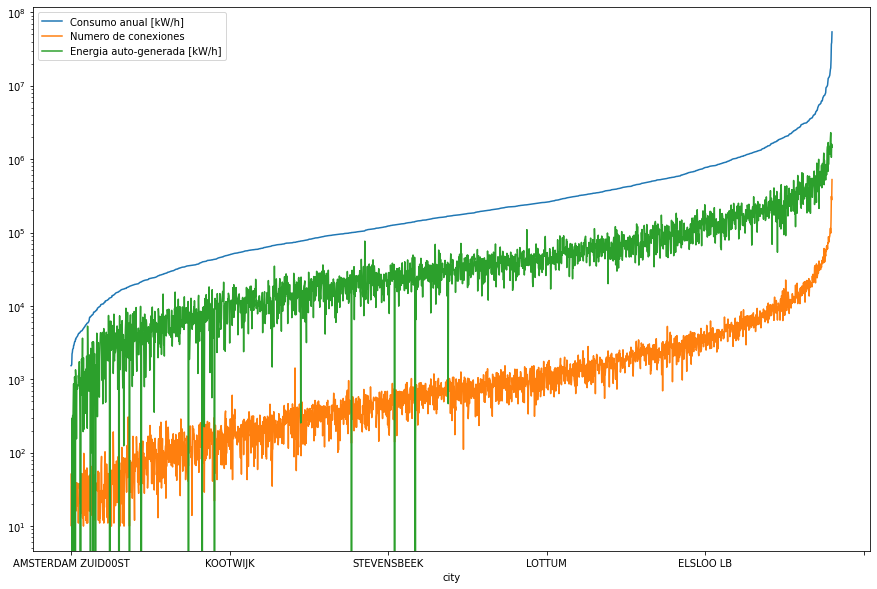

,annual_consume,num_connections,self_production
annual_consume,1.000000,0.978024,0.818989
num_connections,0.978024,1.000000,0.706530
self_production,0.818989,0.706530,1.000000


In [13]:
df_elec_2020_conn = df_elc_2020[['city','annual_consume','num_connections','self_production']]
df_elec_2020_conn = df_elec_2020_conn.groupby('city').sum()

df_elec_2020_conn.sort_values('annual_consume').plot(kind='line')
plt.yscale('log')
plt.legend(['Consumo anual [kW/h]','Numero de conexiones','Energia auto-generada [kW/h]'])
plt.show()

display(df_elec_2020_conn.corr())

Como ilustrado por el grafico de líneas anterior, ubicando las ciudades en el eje X, se puede ver que existe una relacion entre el consumo anual, el numero conexiones y la energia auto-generada en las ciudades. Ordenándolas de forma creciente respecto al consumo anual, se observa que ante mayor consumo por ciudad, se tiene una mayor cantidad de conexiones y mayor energia auto-generada.

La matriz de correlación bajo el grafico refuerza este análisis, con factores de correlación entre el consumo anual y el numero de conexiones con un 97,8% y entre consumo anual y la energia auto-generada con un 81,8%.

## 8. Aumento de consumo de gas y electricidad en el pais.

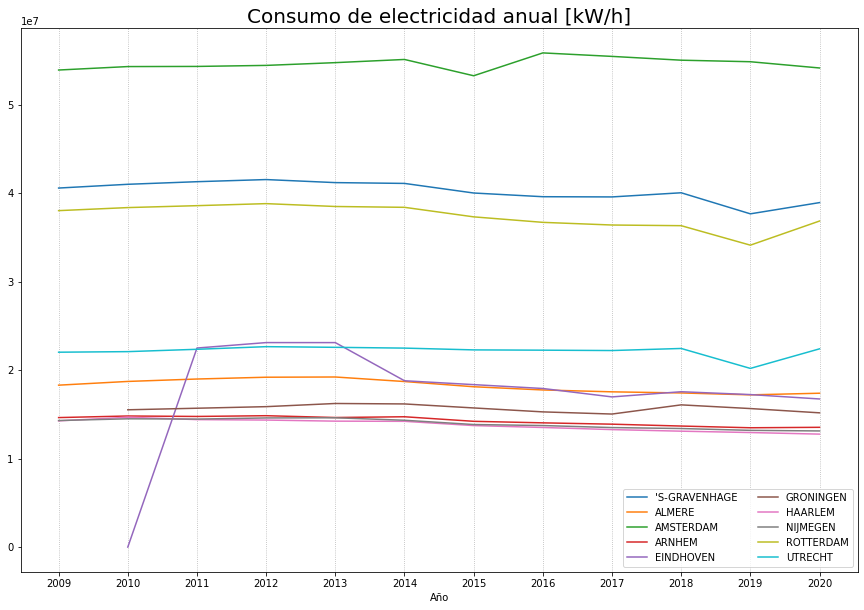

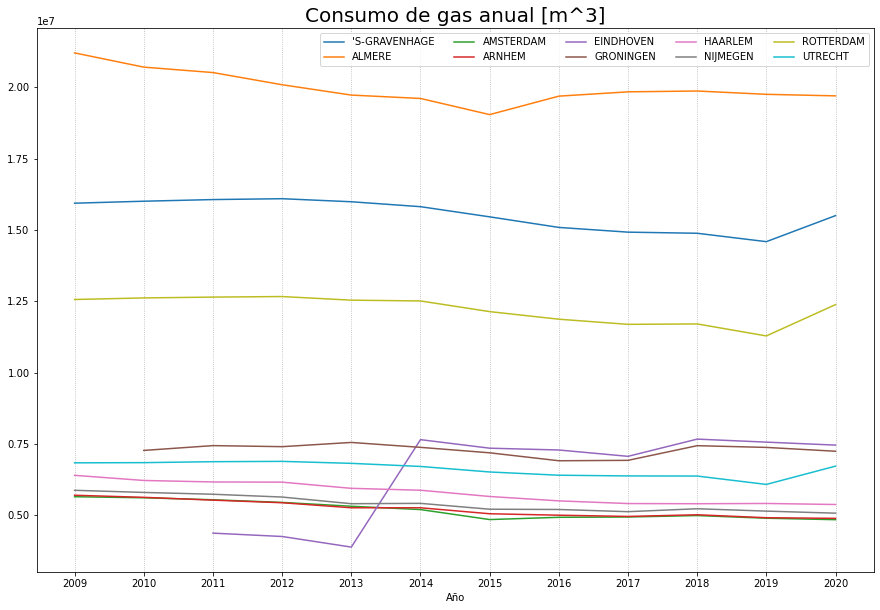

In [14]:
# Electricidad
top10_ciudades = list(df_electricity[['city','num_connections']].groupby('city').sum().sort_values('num_connections').tail(10).index)

df_elec_consum = df_electricity[['year','city','annual_consume']]

lista_total = []
for city in top10_ciudades:
	q = 'city==\"' + city + '\"'
	tabla_ciudad = df_elec_consum.query(q).groupby(['year','city']).sum()
	lista_total.append(tabla_ciudad)

tabla_total = pd.concat(lista_total).groupby(['year','city']).first()

tabla_total = tabla_total.unstack()

tabla_total.plot(kind='line')
plt.legend(["'S-GRAVENHAGE",'ALMERE','AMSTERDAM','ARNHEM','EINDHOVEN','GRONINGEN','HAARLEM','NIJMEGEN','ROTTERDAM','UTRECHT'],loc='lower right',ncol=2)
plt.title("Consumo de electricidad anual [kW/h]",fontsize=20)
plt.xlabel('Año')
plt.grid(axis='x',linestyle=':')
plt.xticks([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])
plt.show()



# Gas
top10_ciudades = list(df_gas[['city','num_connections']].groupby('city').sum().sort_values('num_connections').tail(10).index)

df_gas_consum = df_gas[['year','city','annual_consume']]

lista_total = []
for city in top10_ciudades:
	q = 'city==\"' + city + '\"'
	tabla_ciudad = df_gas_consum.query(q).groupby(['year','city']).sum()
	lista_total.append(tabla_ciudad)

tabla_total = pd.concat(lista_total).groupby(['year','city']).first()

tabla_total = tabla_total.unstack()

tabla_total.plot(kind='line')
plt.legend(["'S-GRAVENHAGE",'ALMERE','AMSTERDAM','ARNHEM','EINDHOVEN','GRONINGEN','HAARLEM','NIJMEGEN','ROTTERDAM','UTRECHT'],loc='upper right',ncol=5)
plt.title("Consumo de gas anual [m^3]",fontsize=20)
plt.xlabel('Año')
plt.grid(axis='x',linestyle=':')
plt.xticks([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])
plt.show()

Se puede ver que en promedio, la cantidad de electricidad y gas que se consume anualmente no varia mucho. Los boxplots a continuacion demuestran que efectivamente la tendencia de los datos no es muy variada, sin embargo, lo que mas varía son los outliers. En algunas ciudades han bajado, como por ejemplo Nijmegen o Haarlem; y otros se han mantenido, por ejemplo 'S-Gravenhage.

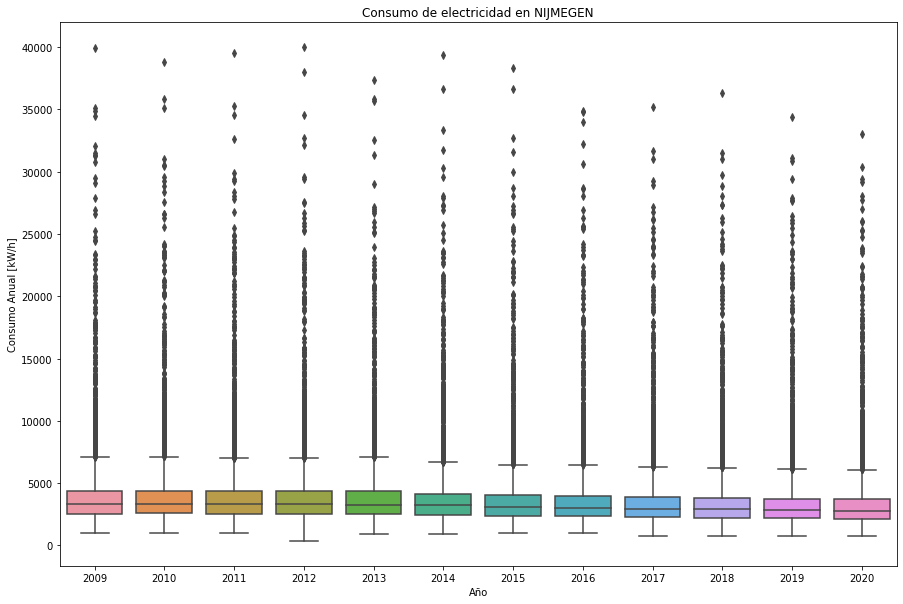

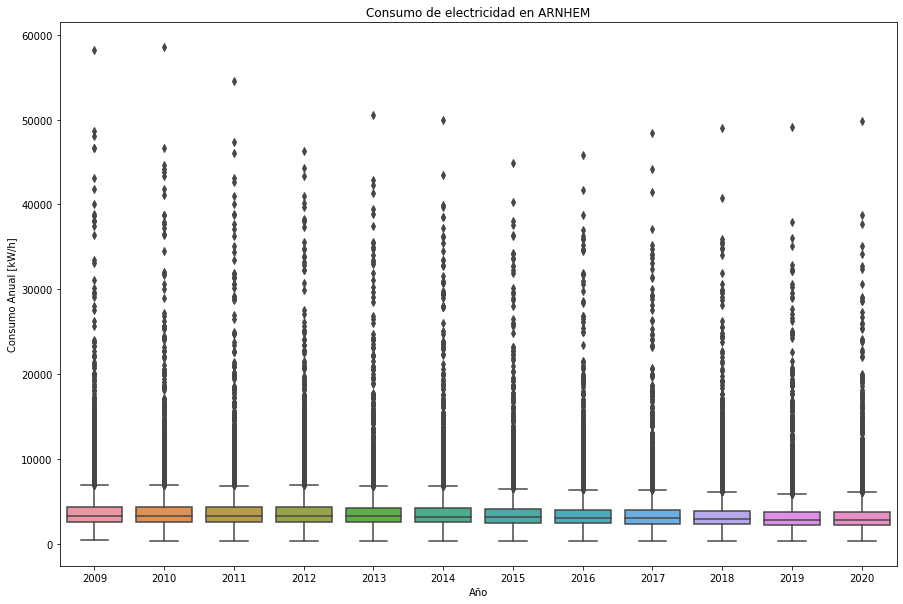

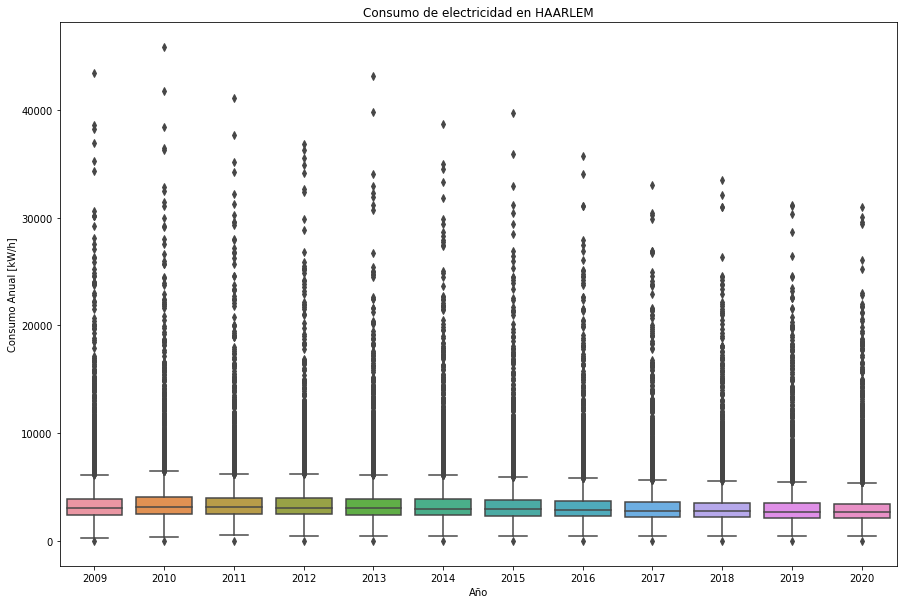

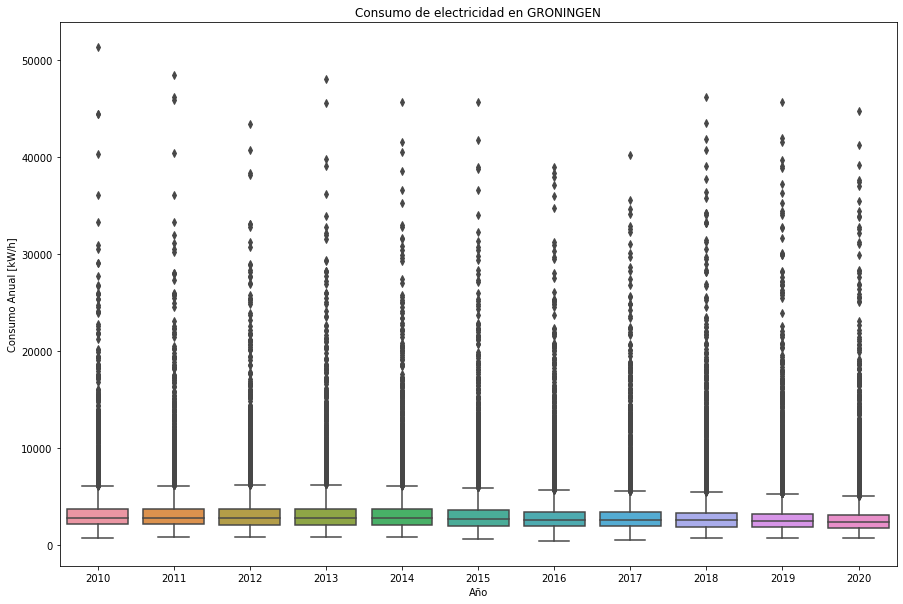

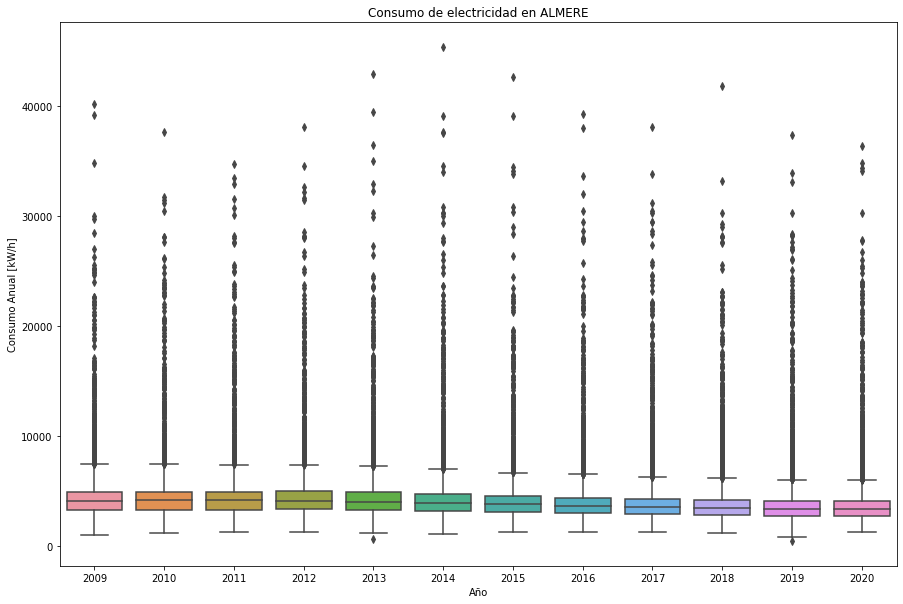

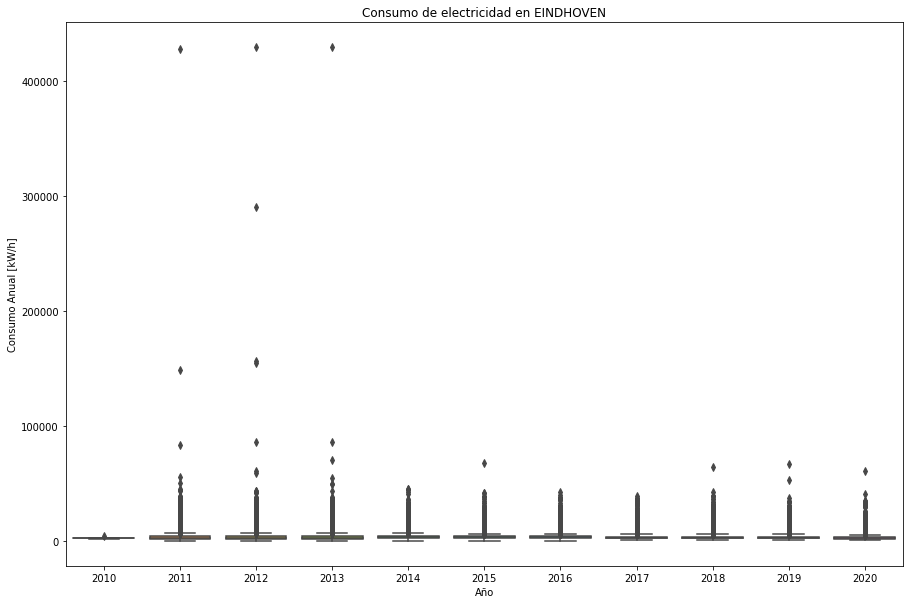

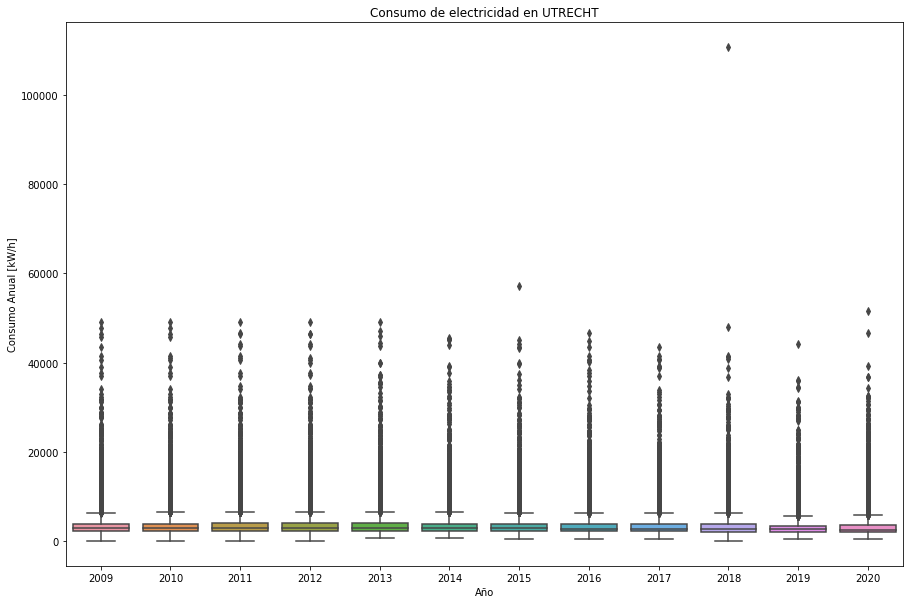

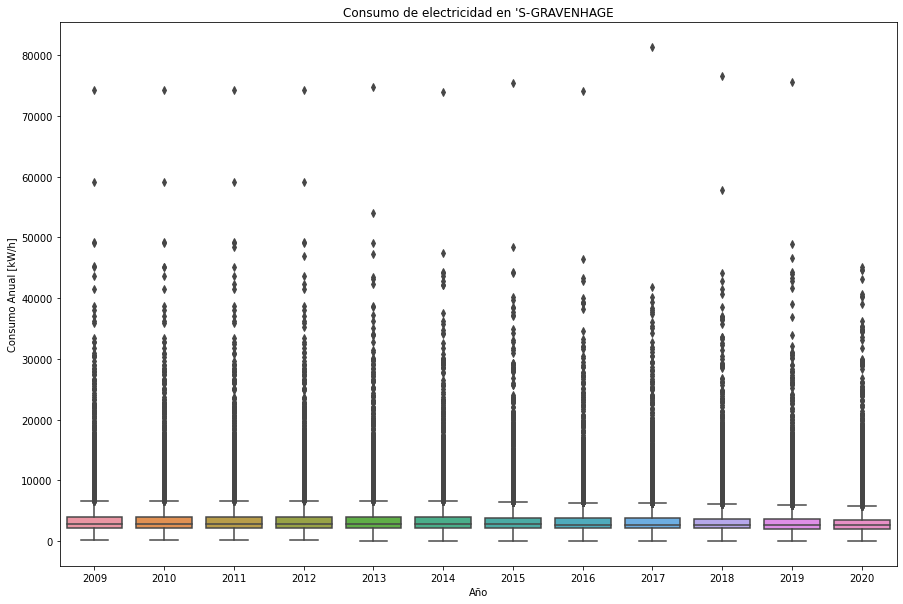

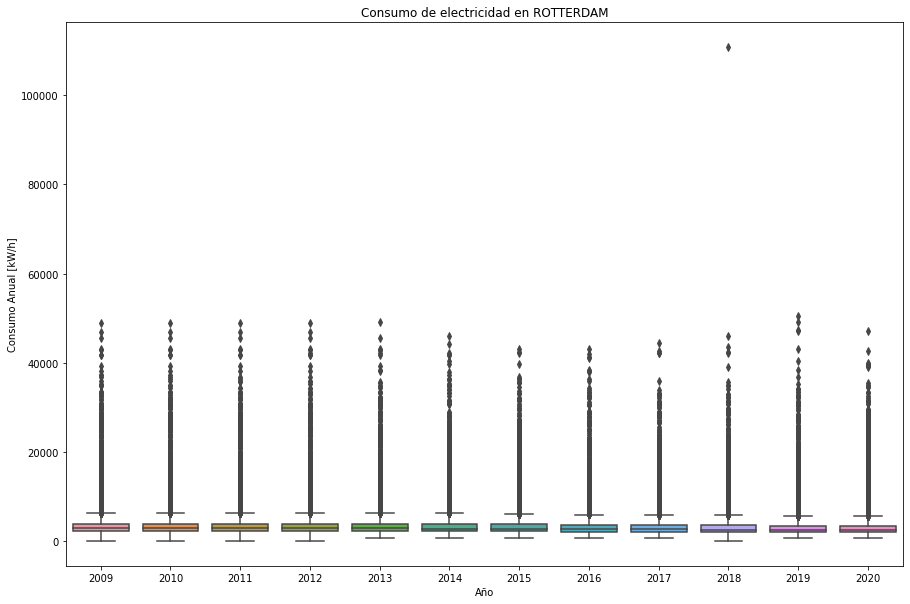

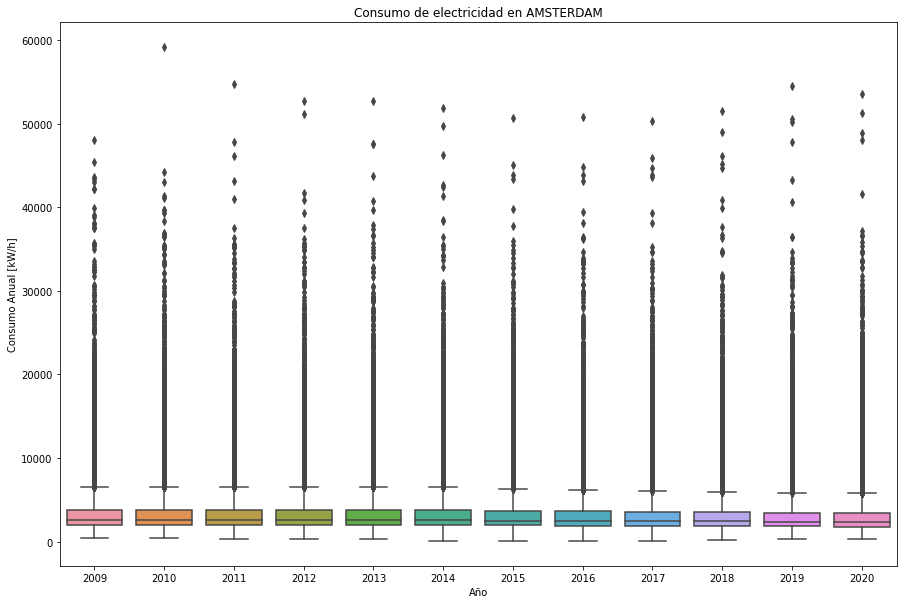

In [15]:
top10_ciudades = list(df_electricity[['city','num_connections']].groupby('city').sum().sort_values('num_connections').tail(10).index)

for city in top10_ciudades:
	q = 'city==\"' + city + '\"'
	df_boxplot = df_electricity.query(q)

	# df_boxplot.plot(kind='box',title="Consumo de electricidad",column='annual_consume',by='year',ylabel='Consumo Anual [kW/h]')
	sn.boxplot(data=df_boxplot, x='year', y='annual_consume')
	plt.title('Consumo de electricidad en ' + city)
	plt.ylabel('Consumo Anual [kW/h]')
	plt.xlabel('Año')
	plt.show()

# df_elec_city_filtered = df_electricity.query('city==' + str(top10_ciudades))
# sn.scatterplot(data=df_elec_city_filtered, x='year', y='annual_consume', hue='city')

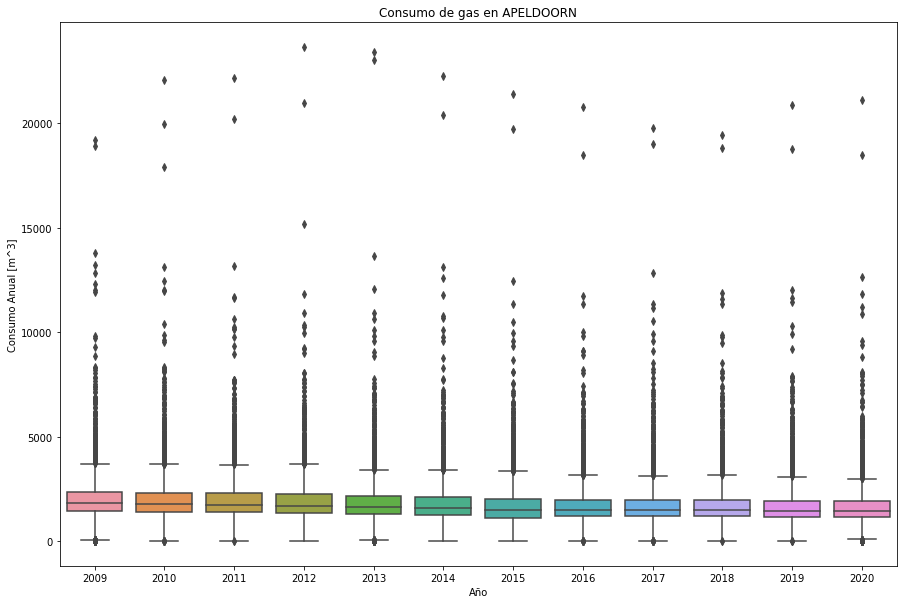

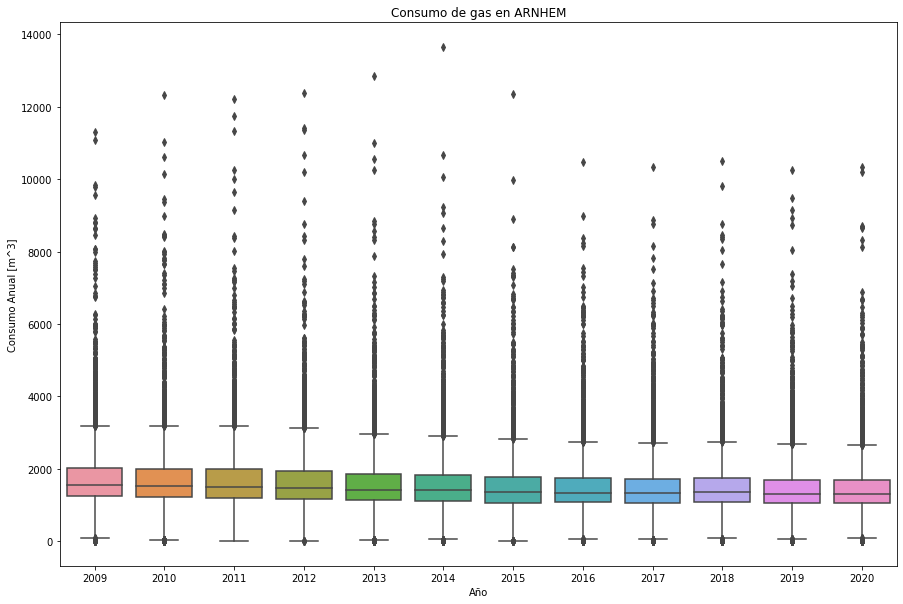

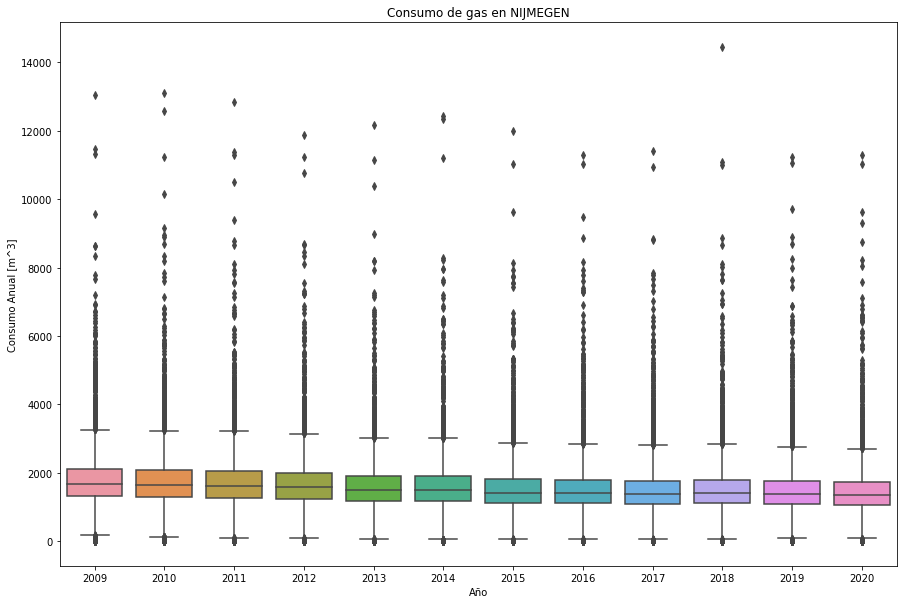

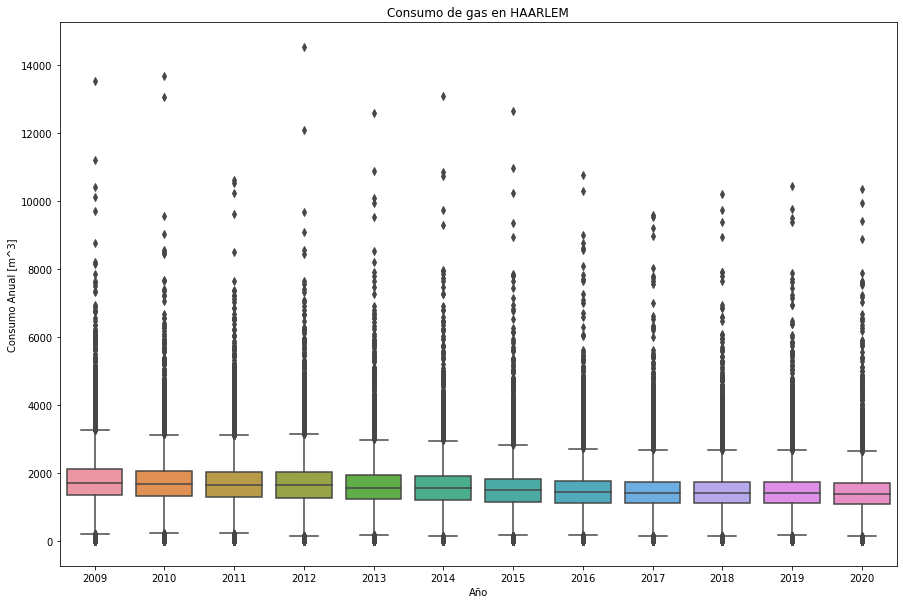

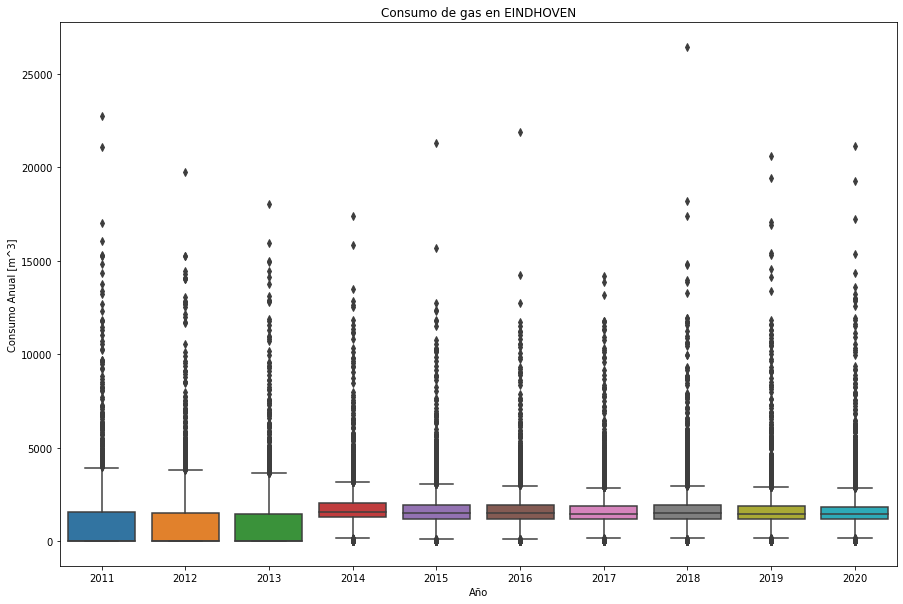

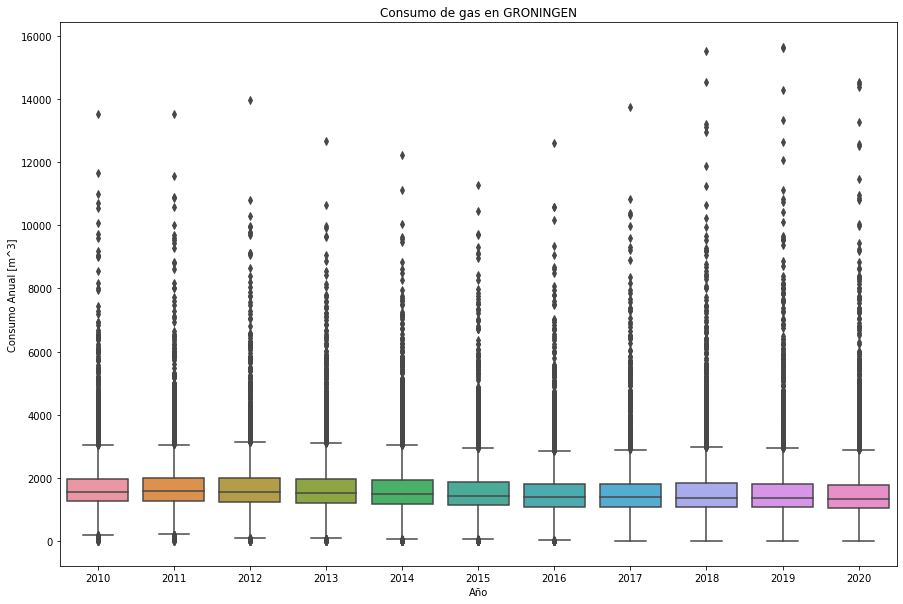

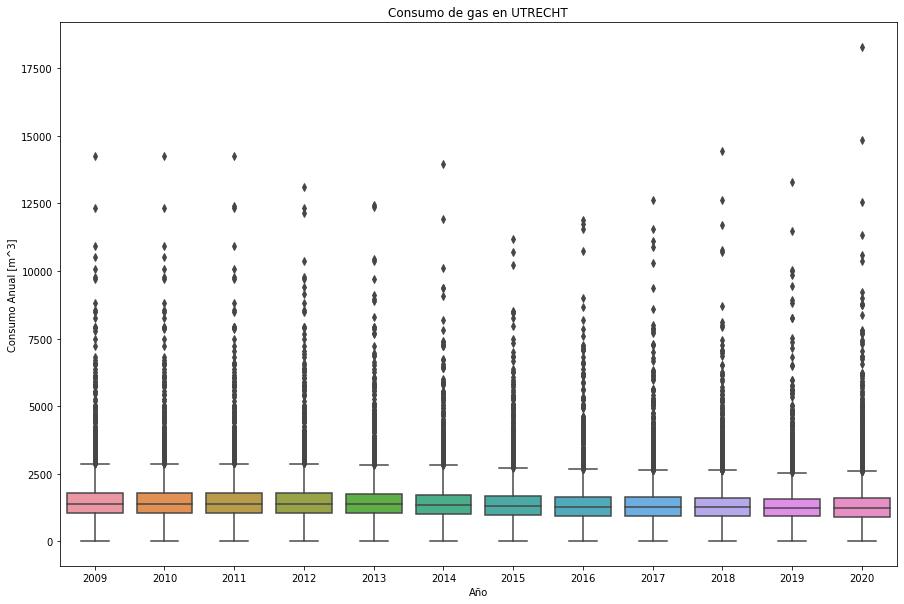

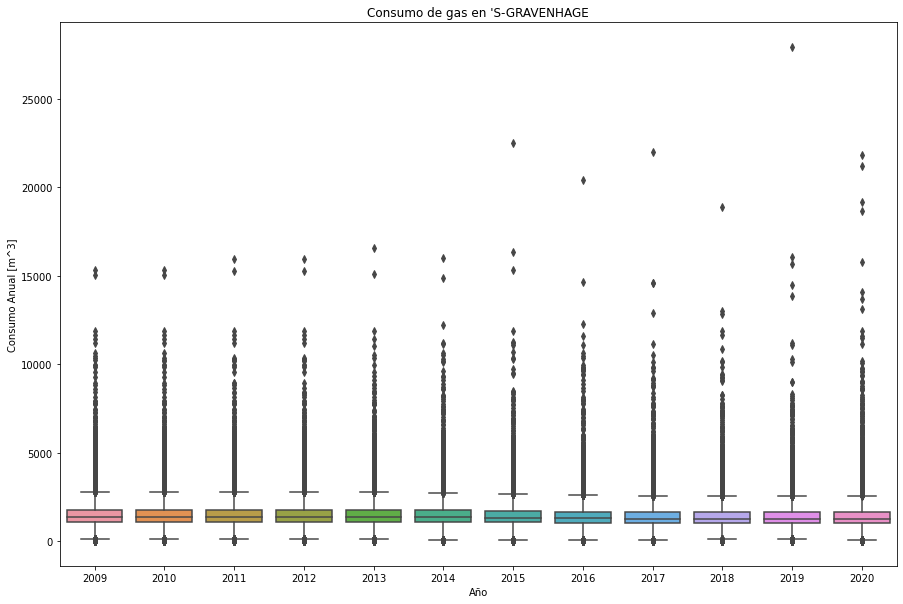

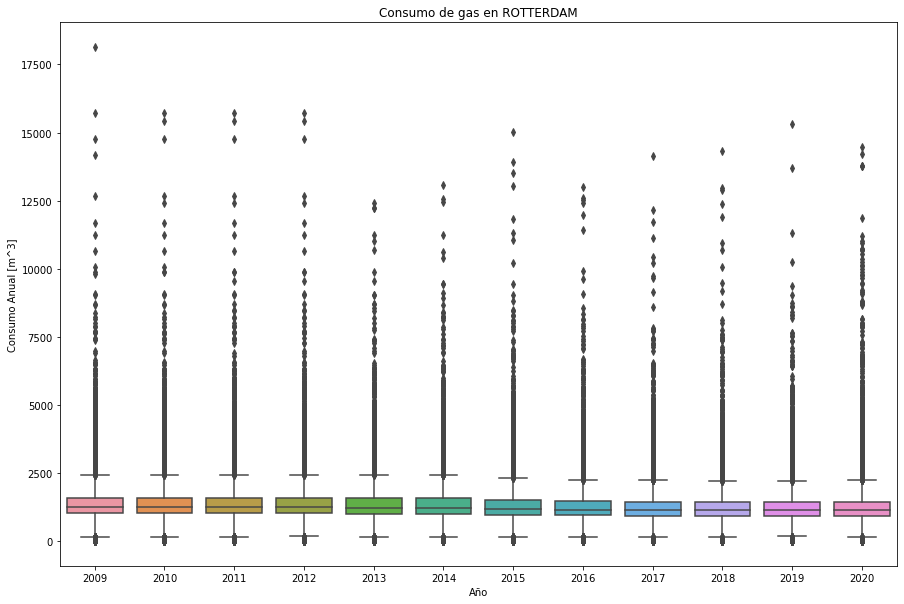

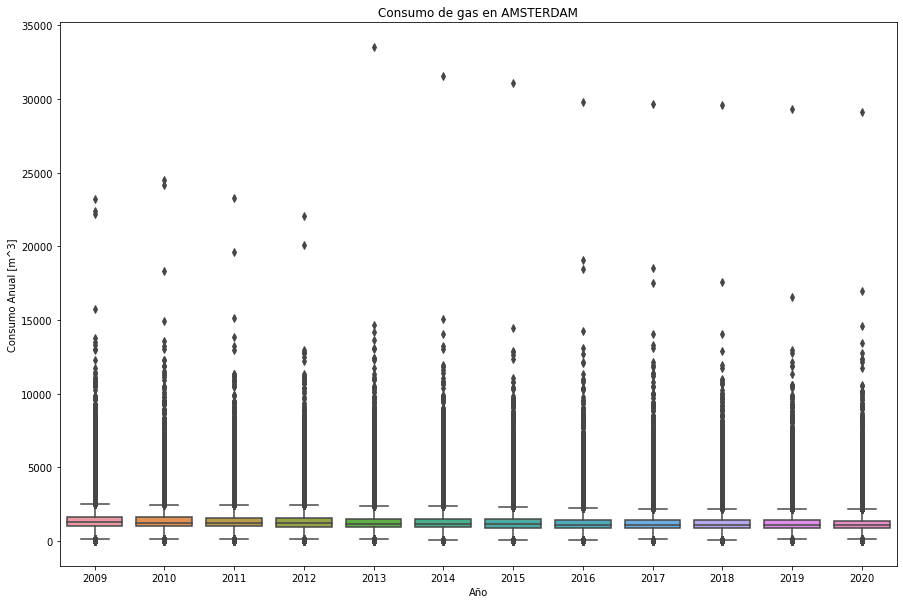

In [16]:
top10_ciudades = list(df_gas[['city','num_connections']].groupby('city').sum().sort_values('num_connections').tail(10).index)

for city in top10_ciudades:
	q = 'city==\"' + city + '\"'
	df_boxplot = df_gas.query(q)

	# df_boxplot.plot(kind='box',title="Consumo de gas",column='annual_consume',by='year',ylabel='Consumo Anual [m^3]')
	sn.boxplot(data=df_boxplot, x='year', y='annual_consume')
	plt.title('Consumo de gas en ' + city)
	plt.ylabel('Consumo Anual [m^3]')
	plt.xlabel('Año')
	plt.show()

Parecido a la tendencia del consumo de electricidad, la tendencia del consumo de gas no varia mucho, sin embargo, se puede notar que los outliers cambian, por ejemplo en Amsterdam hay un nuevo outlier que consume mas gas.

## 9. Aumento de energia auto-generada en el pais.

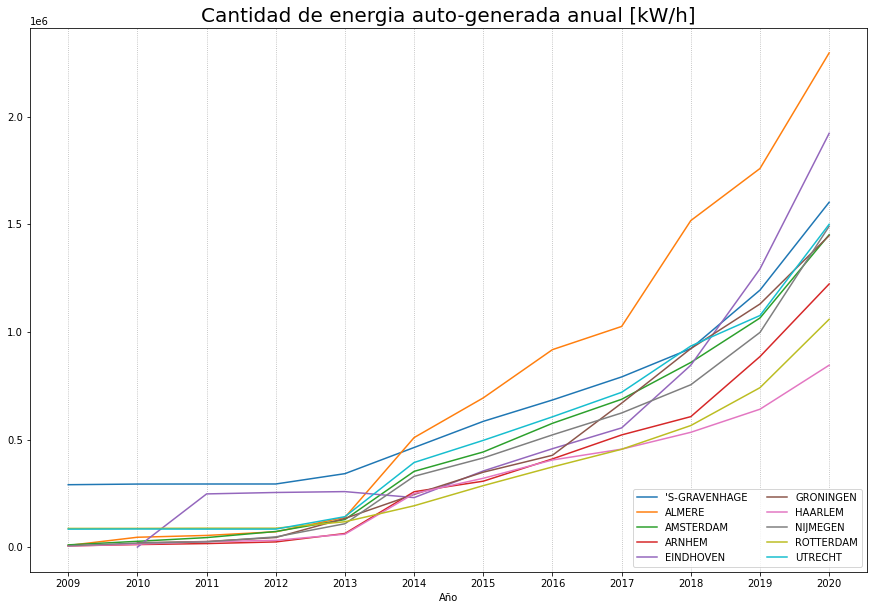

In [17]:
top10_ciudades = list(df_electricity[['city','num_connections']].groupby('city').sum().sort_values('num_connections').tail(10).index)

df_elec_consum = df_electricity[['year','city','self_production']]

lista_total = []
for city in top10_ciudades:
	q = 'city==\"' + city + '\"'
	tabla_ciudad = df_elec_consum.query(q).groupby(['year','city']).sum()
	lista_total.append(tabla_ciudad)

tabla_total = pd.concat(lista_total).groupby(['year','city']).first()

tabla_total = tabla_total.unstack()

tabla_total.plot(kind='line')
plt.legend(["'S-GRAVENHAGE",'ALMERE','AMSTERDAM','ARNHEM','EINDHOVEN','GRONINGEN','HAARLEM','NIJMEGEN','ROTTERDAM','UTRECHT'],loc='lower right',ncol=2)
plt.title("Cantidad de energia auto-generada anual [kW/h]",fontsize=20)
plt.xlabel('Año')
plt.grid(axis='x',linestyle=':')
plt.xticks([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])
plt.show()

A diferencia del grafico anterior, se puede ver notablemente que ha aumentado la cantidad de energia que se autoproduce en las distinas ciudades. En los boxplots a continuacion se puede ver este aumento, sin embargo, ciertas ciudades se han mantenido igual, por ejemplo 'S-Gravenhage.

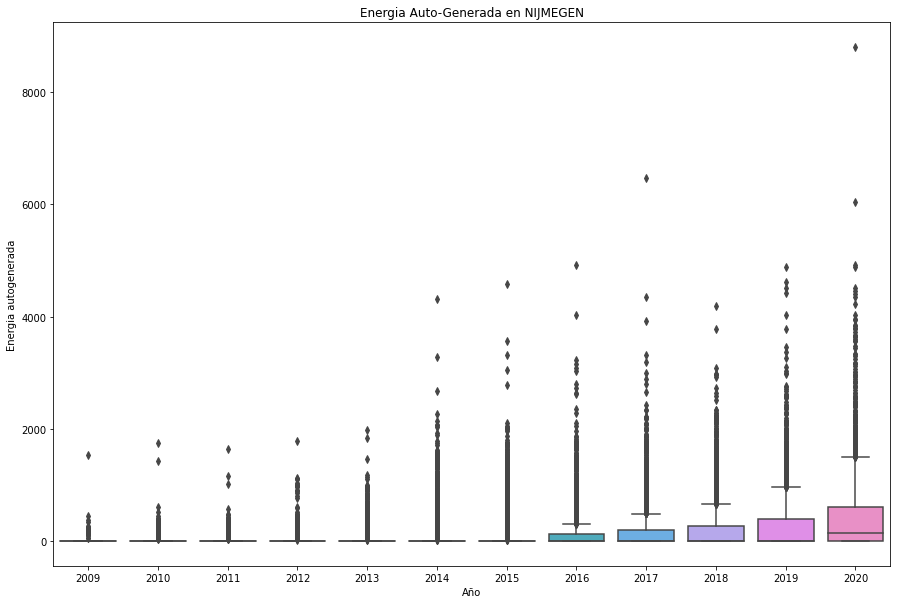

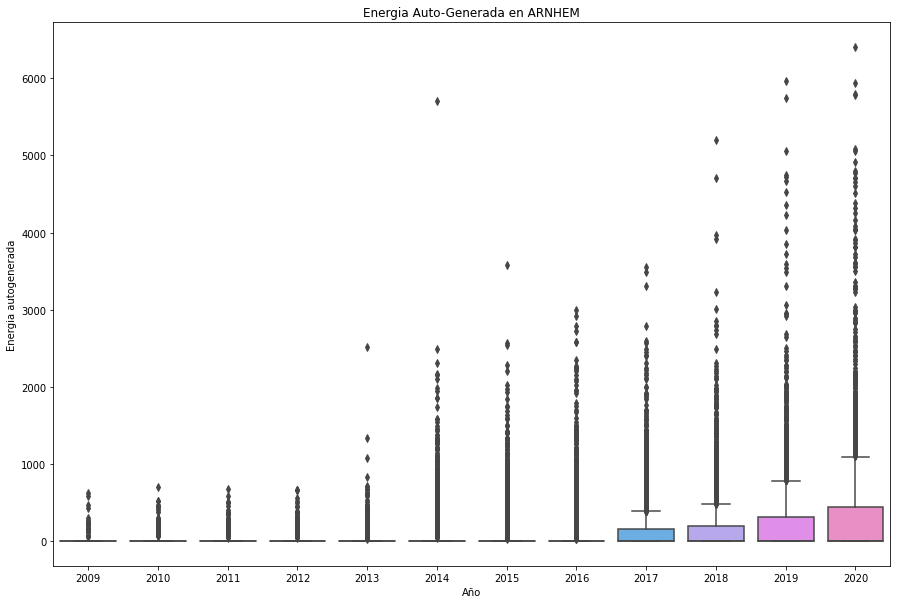

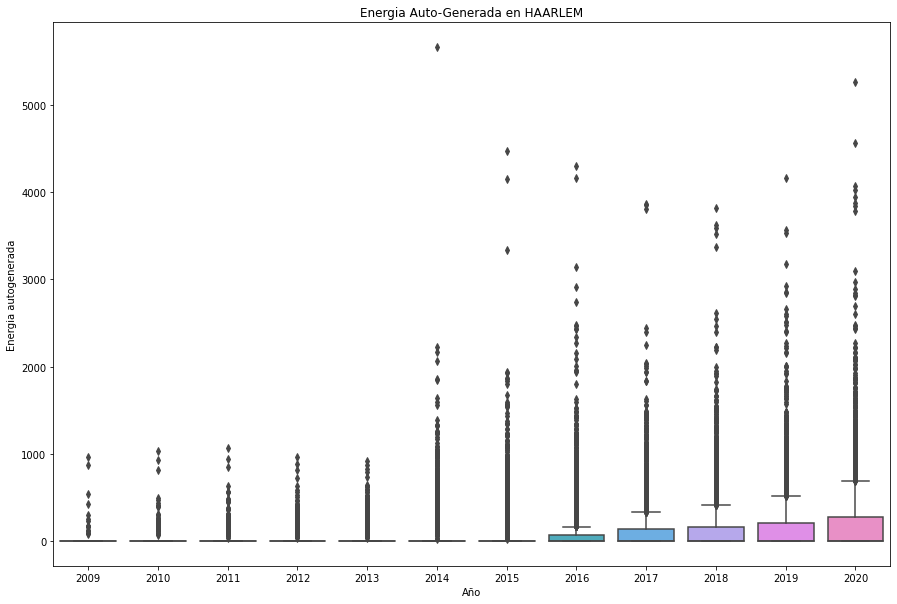

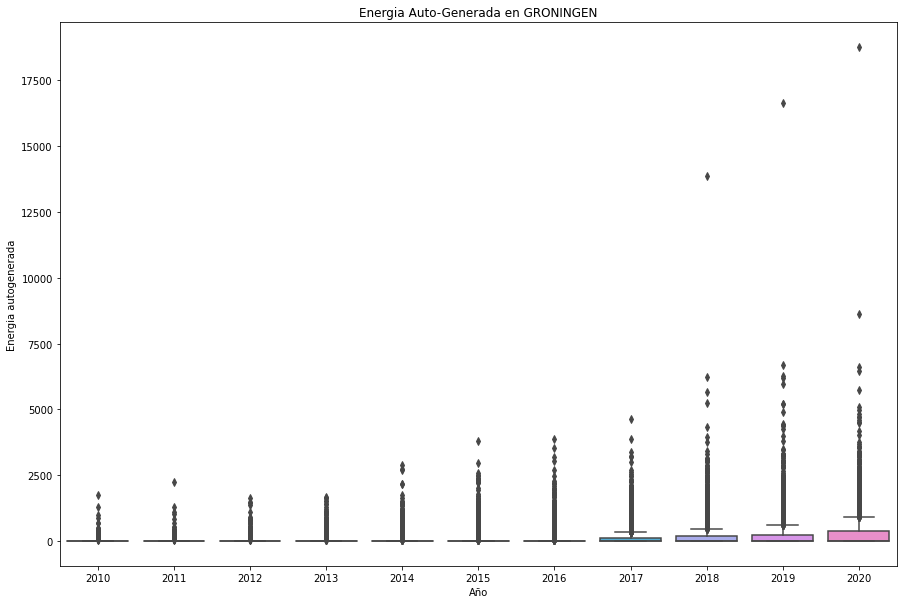

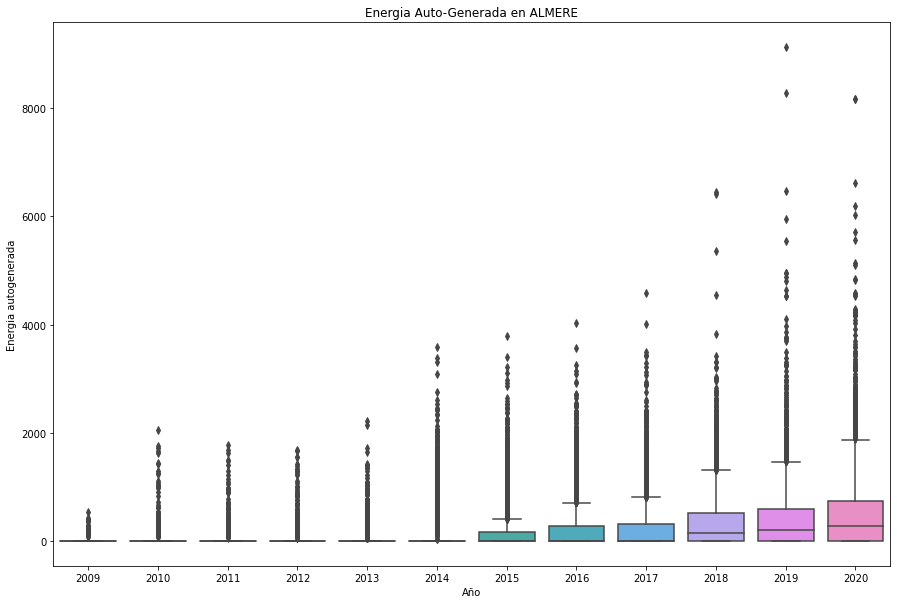

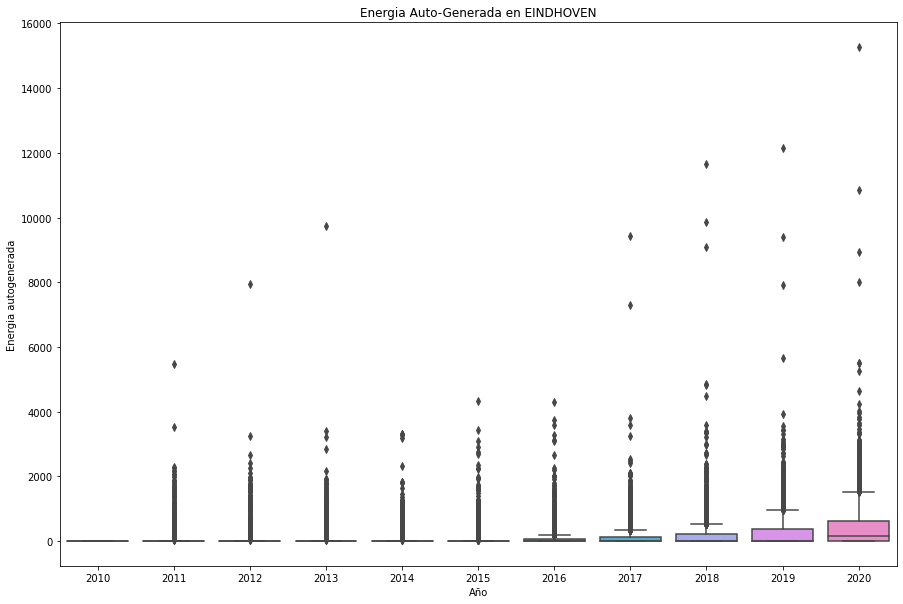

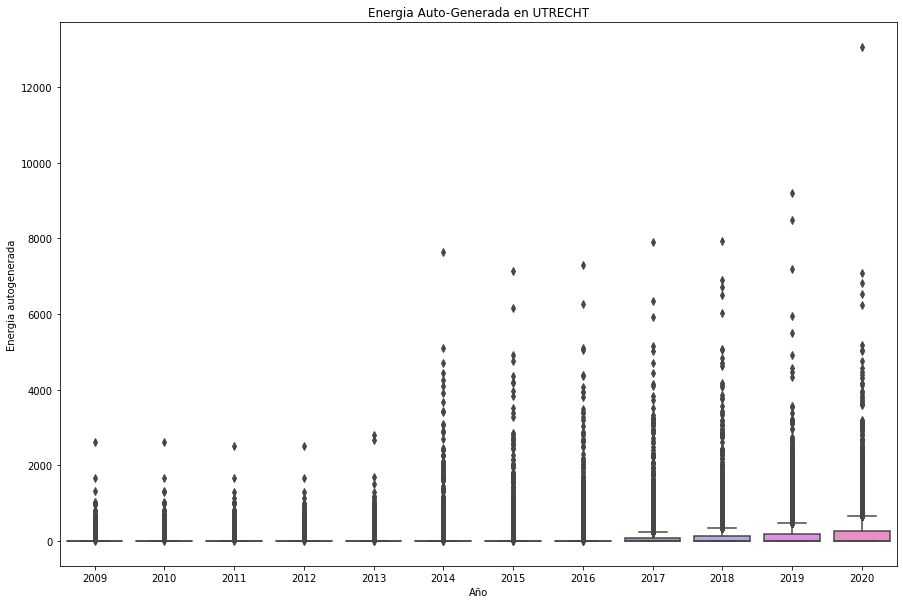

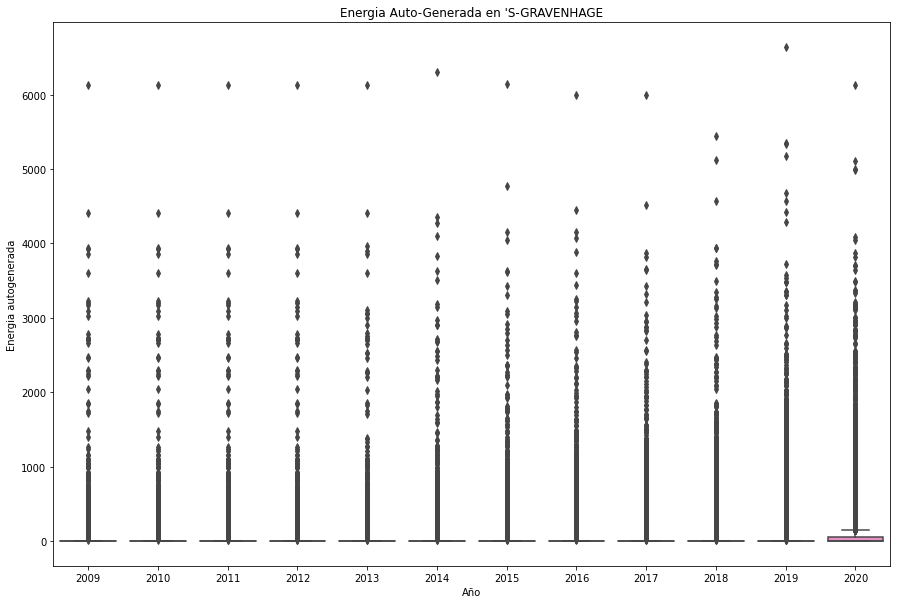

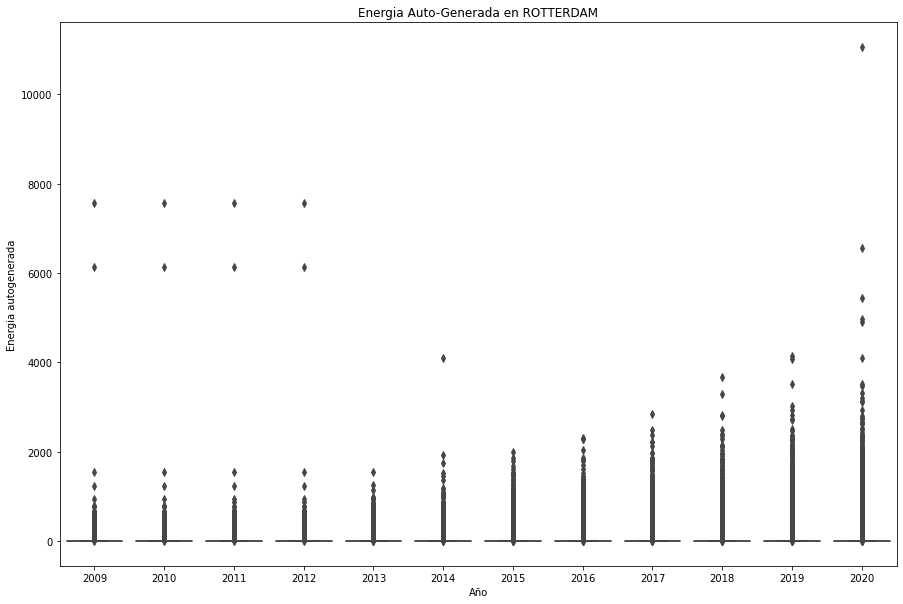

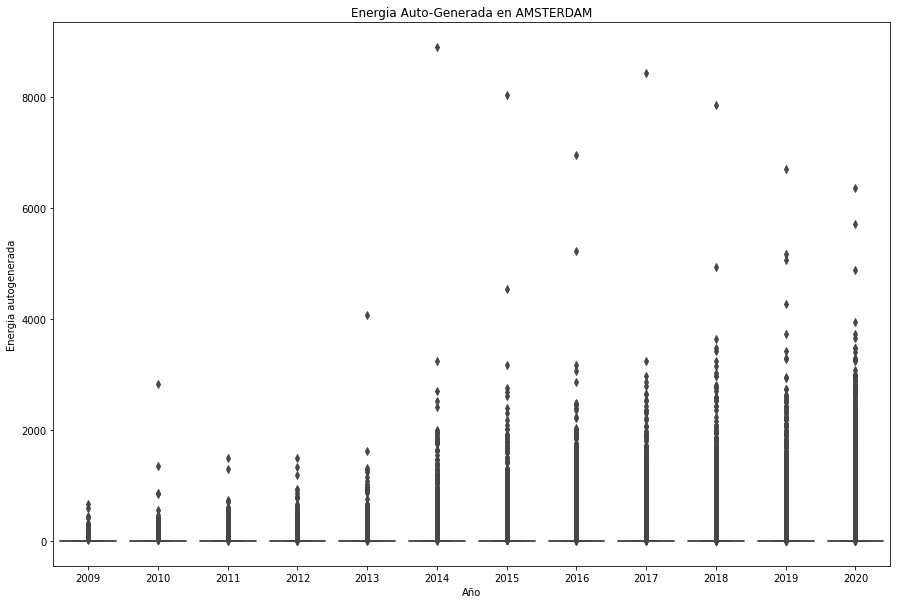

In [18]:
top10_ciudades = list(df_electricity[['city','num_connections']].groupby('city').sum().sort_values('num_connections').tail(10).index)

for city in top10_ciudades:
	q = 'city==\"' + city + '\"'
	df_boxplot = df_electricity.query(q)

	# df_wea.plot(kind='box',title="Energia Auto-Generada",column='self_production',by='year',ylabel='Energia Auto-Generada [kW/h]')
	sn.boxplot(data=df_boxplot,x='year',y='self_production')
	plt.title("Energia Auto-Generada en " + city)
	plt.ylabel("Energia autogenerada")
	plt.xlabel("Año")
	plt.show()

## 10. Analisis libre